

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b> Preliminary Investigation of Time-Series Features in DP02</b> <br>
Contact author: Anastasios Tzanidakis (atzanida@uw.edu)<br>
Last verified to run: -  08/203/2023<br>
LSST Science Piplines version: - Weekly 2023_08 Large Container<br>
Container Size: Large <br>

## Abstract & Findings

In this short notebook, we summarize at high level our findings of the time-series features released by the Data Preview (DP) 0.2. We do not find any anomalous or spurious trends amongst the time-series features calculated as part of the `DiaSource` table that is measured upon the difference images. Amonst the rich multi-band time-series features we explored the covariances and found in some instances both weakly and strongly correlated features. 

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy.ma as ma
import matplotlib
from astropy.coordinates import SkyCoord
cm = matplotlib.cm.get_cmap('jet')

%matplotlib inline
%config InlineBackend.figure_format = "png"
from tqdm import tqdm

from matplotlib import rcParams
rcParams['savefig.dpi'] = 150
plt.rcParams['figure.dpi'] = 50 
rcParams['font.size'] = 20
plt.rc('font', family='serif')

from lsst.rsp import get_tap_service, retrieve_query
import astropy.units as u
from tqdm import tqdm 
from astropy.table import Table
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.ticker as plticker
import matplotlib.patches as patches
from astropy import visualization as aviz
import lsst.daf.butler as dafButler
import lsst.geom
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
import lsst.afw.cameraGeom as cameraGeom
from lsst.obs.decam import DarkEnergyCamera

### TAP Service

In [4]:
# create the TAP service client
service = get_tap_service("tap")

# we will all use the same input coordinates and radii
center_coords = "62, -32"

radius_deg = 2 # degrees

## Helper Functions and Query

In [5]:
def xmatch_diasource(cent_coord, diaObjID, rad=0.1):
    """ Crossmatch DIAObjectID to the DiaSoure table given the coordinates and DIAObjectiID. 
    
        Parameters
        ----------
            cent_coord (str): ra, dec coordinates in degrees
            diaObjID (int): DiaObjectID
            rad (float): Crossmatch radius. Default is 0.1 degrees.
        
        Returns 
        -------
            DiaSouce Table (astropy.Table)
    """
    
    return service.search(f"SELECT ra, decl, filterName, ccdVisitId "
                  "FROM dp02_dc2_catalogs.DiaSource "
                 "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                 f"CIRCLE('ICRS', {cent_coord}, {rad})) = 1 "
                  f"AND diaObjectId = {diaObjID}").to_table()


def xmatch_source(cent_coord, ccd_vis, rad=0.01):
    """ Crossmatch CCD Visit ID from the DiaSource to the Source table.

    Parameters
    ----------
        cent_coord (str): ra, dec coordinates in degrees
        ccd_vis (int): CCD visit ID
        rad (float): Crossmatch radius. Default is 0.01 degrees.

    Returns 
    -------
        Source Table (astropy.Table)
    """

    _table = service.search(f"SELECT ra, decl, coord_ra, coord_dec, ccdVisitId, "
              "band, instrument, "
              "visit, sourceId, detector "
          "FROM dp02_dc2_catalogs.Source "
         "WHERE CONTAINS(POINT('ICRS', ra, decl), "
         f"CIRCLE('ICRS', {cent_coord}, {rad})) = 1 "
          f"AND ccdVisitId = {ccd_vis}").to_table()

    # In crowded fields we suspect this will cause issues; let's to the closest x-match based on location
    targ_pos = SkyCoord(ra=float(cent_coord.split(",")[0])*u.deg, dec=float(cent_coord.split(",")[1])*u.deg)
    table_pos = SkyCoord(ra=_table['ra'], dec=_table['decl'])    
    d_sep = targ_pos.separation(table_pos).arcsecond

    match = np.argmin(d_sep)
    return _table[match]


def DiaSouceOID(dia_ID, columns="*", band='r', center_coords=center_coords, rad=1):
    """ Given the DiaObjectiD this function will return the DiaSource catalog for a specific photometric filter and crossmatch radius. 

    Parameters
    ----------
        dia_ID (int): DiaObjectID
        columns (str): Supports all columns listed in the DP02 columns page. Default is all columns (*).
        band (str): Photometric LSST band - supports ugrizy. Default r. For all photometric filters use 'all'
        center_coords (str): Central coordinates of query. 
        rad (float): crossmatch radius. Default is 1 deg.

    Returns 
    -------
        DiaSource Table (astropy.Table)
    """
    _table = service.search(f"SELECT {columns} "
                      "FROM dp02_dc2_catalogs.DiaSource "
                     "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                     f"CIRCLE('ICRS', {center_coords}, {rad})) = 1 "
                      f"AND diaObjectId = {dia_ID}").to_table()
    if band=='all':
        return _table
    else:
        return _table[_table['filterName']==band]

In [6]:
results = service.search("SELECT ra, decl, nDiaSources, diaObjectId, "
                         "uPSFluxNdata, gPSFluxNdata, rPSFluxNdata, iPSFluxNdata, zPSFluxNdata, yPSFluxNdata, "
                         "uPSFluxChi2, gPSFluxChi2, rPSFluxChi2, iPSFluxChi2, zPSFluxChi2, yPSFluxChi2 "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                         f"CIRCLE('ICRS', {center_coords}, {radius_deg})) = 1 "
                        "AND uPSFluxNdata > 0"
                        "AND gPSFluxNdata > 0"
                        "AND rPSFluxNdata > 0"
                        "AND iPSFluxNdata > 0"
                        "AND zPSFluxNdata > 0"
                        "AND yPSFluxNdata > 0"
                        "AND uPSFluxChi2 > 0 "
                        "AND gPSFluxChi2 > 0 "
                        "AND rPSFluxChi2 > 0 "
                        "AND iPSFluxChi2 > 0 "
                        "AND zPSFluxChi2 > 0 "
                        "AND yPSFluxChi2 > 0 ")

table = results.to_table()

## Flux

Comparing DP0.2 Time Series Flux Measurements

Categories: 
1. Aperture Flux (apflux): Aperture photometry on difference image
2. PS Flux (psflux): PSF photometry on difference image
3. Total Flux (totflux): Forced PSF flux measured on the direct image

In [7]:
def dia_flux_comp(DiaObjectID, ra, dec, band='all'):
    """Takes a list of DiaObjectID's, coordinates, and returns a compiled list of apFlux, 
        psFlux, totFlux as a single Nx3 array, and filterName given a filter.
        

        Parameters
        ----------
            DiaObjectID (int): DIA Object ID
            ra, dec (float): coordinates in degrees
            band (str): photometric bandpasss. Default is `all` for ugrizy. 

        Returns 
        -------
            APFlux, PSFlux, TotFlux, and filer
    """
    flux_data = []
    flt = []
    tot_flux = []

    for _id, _ra, _dec in tqdm(zip(DiaObjectID, ra, dec)):
        _s = DiaSouceOID(_id,
                        columns="apFlux, psFlux, totFlux, filterName",
                        center_coords=f"{_ra}, {_dec}",
                        rad=0.0001, band=band)

        _flux_values = np.column_stack((_s['apFlux'], _s['psFlux'], _s['totFlux']))
        flux_data.extend(_flux_values)
        flt.extend(_s['filterName'])
        tot_flux.extend(_s['totFlux'])

    ap_flux_ps_flux_tot_flux = np.array(flux_data, dtype=np.float64)
    flt = np.array(flt)

    return ap_flux_ps_flux_tot_flux, flt

In [8]:
# Let's look at the first 1_000 entries
res, _flt_match = dia_flux_comp(table['diaObjectId'][0:1_000], 
                                table['ra'][0:1_000],
                                table['decl'][0:1_000], band='all')

1000it [03:17,  5.06it/s]


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def plot_2d_histogram(res, _flt_match, x_col=0, y_col=1, x_label='apFlux', y_label='psFlux', font_size=12):
    """Helper plotting function. Supports apFlux, psFlux, and totFlux"""
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    clr = ['teal', 'seagreen', 'crimson', 'orange', 'orangered', 'saddlebrown']
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    for idx, filter_name in enumerate(filters):
        ax = axs[idx // 3, idx % 3]
        x = res[:, x_col][_flt_match == filter_name]
        y = res[:, y_col][_flt_match == filter_name]

        # Remove inf and NaN values from the data
        valid_indices = np.isfinite(x) & np.isfinite(y)
        x = x[valid_indices]
        y = y[valid_indices]

        # Calculate the correlation coefficient (R) and p-value using scipy
        correlation_coefficient, p_value = pearsonr(x, y)

        # Plot the scatter points
        ax.scatter(x, y, c=clr[idx], s=5, alpha=0.5)

        ax.set_xlabel(f'{x_label} [$\mu$Jy]')
        ax.set_ylabel(f'{y_label} [$\mu$Jy]')
        ax.set_title(f'Filter: {filter_name}')

        # Add the correlation coefficient and p-value text boxes
        ax.text(0.95, 0.95, f'R = {correlation_coefficient:.2f}', transform=ax.transAxes, ha='right', va='top', fontsize=font_size, bbox=dict(facecolor='white', alpha=0.8))
        ax.text(0.05, 0.95, f'p-value = {p_value:.3f}', transform=ax.transAxes, ha='left', va='top', fontsize=font_size, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()


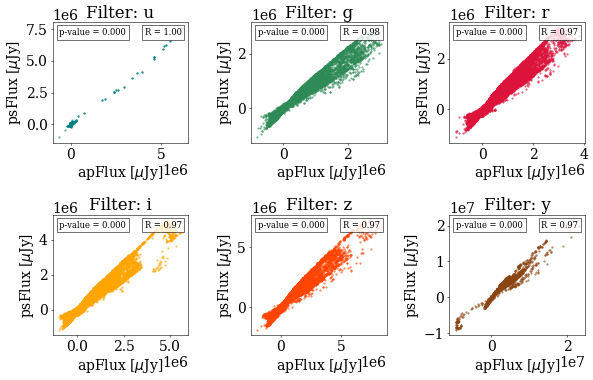

In [40]:
plot_2d_histogram(res, _flt_match, x_col=0, y_col=1, x_label='apFlux', y_label='psFlux')

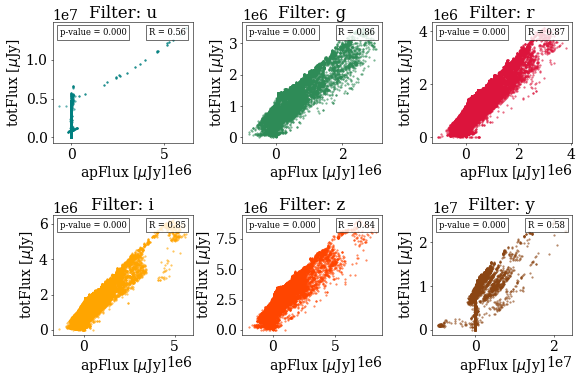

In [41]:
plot_2d_histogram(res, _flt_match, x_col=0, y_col=2, x_label='apFlux', y_label='totFlux')

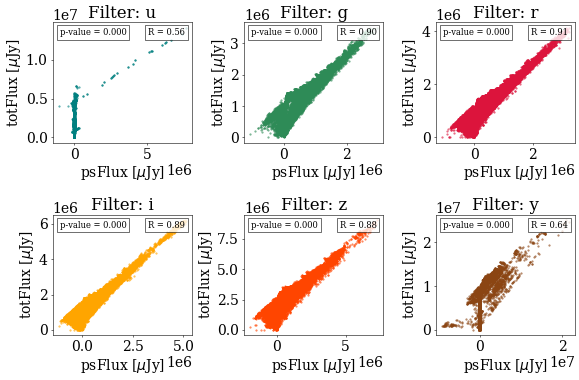

In [42]:
plot_2d_histogram(res, _flt_match, x_col=1, y_col=2, x_label='psFlux', y_label='totFlux')

In the above panels, we want to explore the correlations that exist between the various flux measurements that are reported in DP.0.2.


First, let me summarize what the different flux measurements mean for the reader, you can find out more by reading the documentation [here](https://dm.lsst.org/sdm_schemas/browser/dp02.html#DiaObject).

- `PsFlux`: Flux derived from linear least-squares fit of PSF model.

- `TotFlux`: Forced PSF flux measured on the direct image.

- `ApFlux`: Flux within 12.0-pixel aperture.

Remember that these flux values are reported on the single-epoch difference images according to the `DiaSource` table.


Throuhgout all flux measurements, we see positive correlations. In some instances, most noticably in the u bandpass, we note the vertical ~0 $\mu Jy$ `psFlux`feature. By exploring the correlations that existi within the various flux measurements, we we find some trends that might be useful for converting one type to the other, especially useful for the time-series feature alerts.

## Exploring Time-Series Features in `DiaObject`

Here we want to generate a series of distribution plots looking at basic time series features...

In [13]:
results = service.search("SELECT ra, decl, nDiaSources, diaObjectId, "
                         "uPSFluxNdata, gPSFluxNdata, rPSFluxNdata, iPSFluxNdata, zPSFluxNdata, yPSFluxNdata, "
                         "uPSFluxChi2, gPSFluxChi2, rPSFluxChi2, iPSFluxChi2, zPSFluxChi2, yPSFluxChi2, * "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                         f"CIRCLE('ICRS', {center_coords}, {5})) = 1 "
                        "AND uPSFluxNdata > 0"
                        "AND gPSFluxNdata > 0"
                        "AND rPSFluxNdata > 0"
                        "AND iPSFluxNdata > 0"
                        "AND zPSFluxNdata > 0"
                        "AND yPSFluxNdata > 0"
                        "AND uPSFluxChi2 > 0 "
                        "AND gPSFluxChi2 > 0 "
                        "AND rPSFluxChi2 > 0 "
                        "AND iPSFluxChi2 > 0 "
                        "AND zPSFluxChi2 > 0 "
                        "AND yPSFluxChi2 > 0 ")

table = results.to_table()

In [14]:
len(table)

48977

In [15]:
from scipy import stats

def plot_distributions(data_table, flt='u', color='lightpink'):
    # Define the columns to include
    columns = [
        'PSFluxChi2', 
        'PSFluxMAD',
        'PSFluxMax', 
        'PSFluxMaxSlope',
        'PSFluxMean',
        'PSFluxMin', 
        'PSFluxPercentile05',
        'PSFluxPercentile25', 
        'PSFluxPercentile50', 
        'PSFluxPercentile75', 
        'PSFluxPercentile95', 
        'PSFluxSigma', 
        'PSFluxSkew', 
        'PSFluxStetsonJ'
    ]
    columns = [flt + s for s in columns]

    # Extract the data from the astropy.table and convert to NumPy array
    data = np.array([list(data_table[column]) for column in columns])

    # Create the figure and subplots
    n_columns = len(columns)
    n_rows = (n_columns - 1) // 3 + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(12, 4 * n_rows))

    # Generate the panel of distributions
    for i, ax in enumerate(axes.flat):
        if i < n_columns:
            # Exclude NaN values from the data
            valid_data = data[i][~np.isnan(data[i])]

            # Scale the data by subtracting the mean and dividing by the standard deviation
            scaled_data = (valid_data - np.mean(valid_data)) / np.std(valid_data)

            # Plot the histogram
            ax.hist(scaled_data, bins=20, alpha=0.5, color=color)

            # Calculate summary statistics
            median = np.median(scaled_data)
            std = np.std(scaled_data)
            skewness = stats.skew(scaled_data)
            kurtosis_val = stats.kurtosis(scaled_data)

            # Add lines for median and 1-sigma limits
            ax.axvline(median, color='black', linestyle='solid', linewidth=2)
            ax.axvline(median - std, color='gray', linestyle='dashed', linewidth=2, alpha=0.5)
            ax.axvline(median + std, color='gray', linestyle='dashed', linewidth=2, alpha=0.5)

            # Summary text
            summary_text = f"Median: {np.median(valid_data):.2f}\nStd: {np.std(valid_data):.2f}\nSkewness: {skewness:.2f}\nKurtosis: {kurtosis_val:.2f}"

            # Add summary text box in the top right corner
            ax.text(0.6, 0.95, summary_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round'))

            # Set the title and x-axis label
            ax.set_title(columns[i])
            ax.set_xlabel('Normalized Value')
            ax.set_ylabel('Frequency')
            ax.set_yscale('log')

    # Remove empty subplots if any
    if n_columns < len(axes.flat):
        for j in range(n_columns, len(axes.flat)):
            fig.delaxes(axes.flat[j])

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Display the plot
    plt.show()


/tmp/ipykernel_1733/1301879276.py:24: UserWarning: Warning: converting a masked element to nan.
  data = np.array([list(data_table[column]) for column in columns])


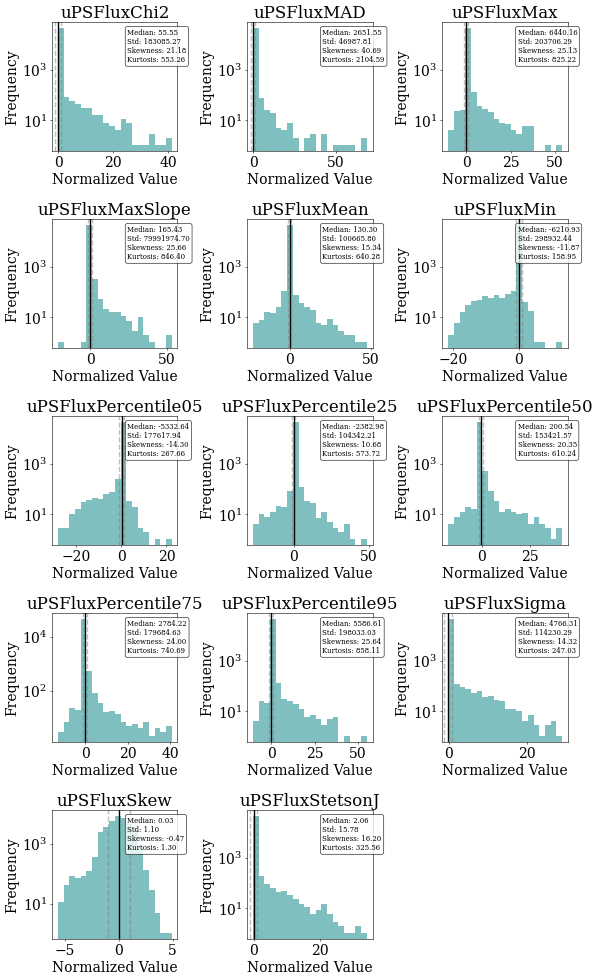

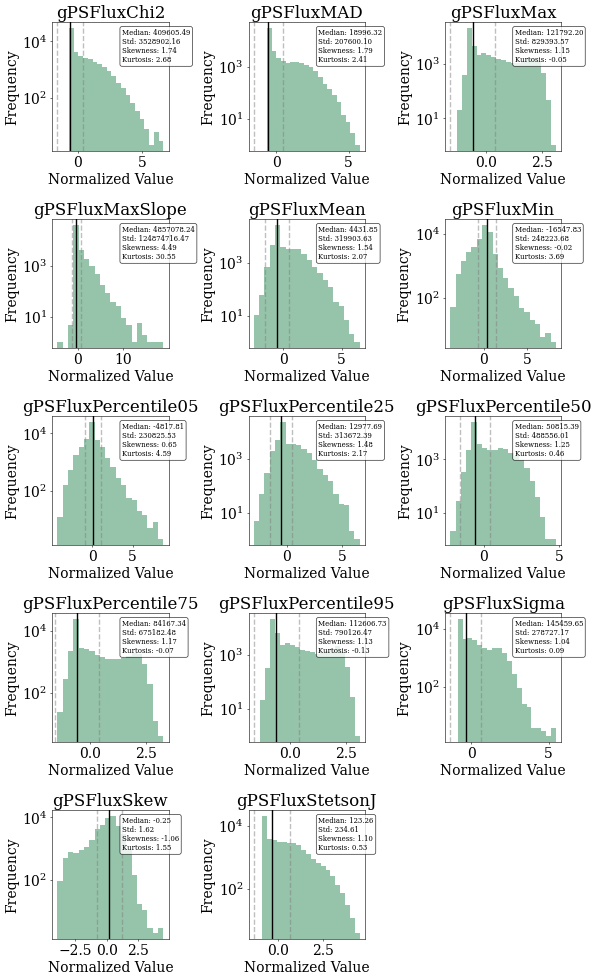

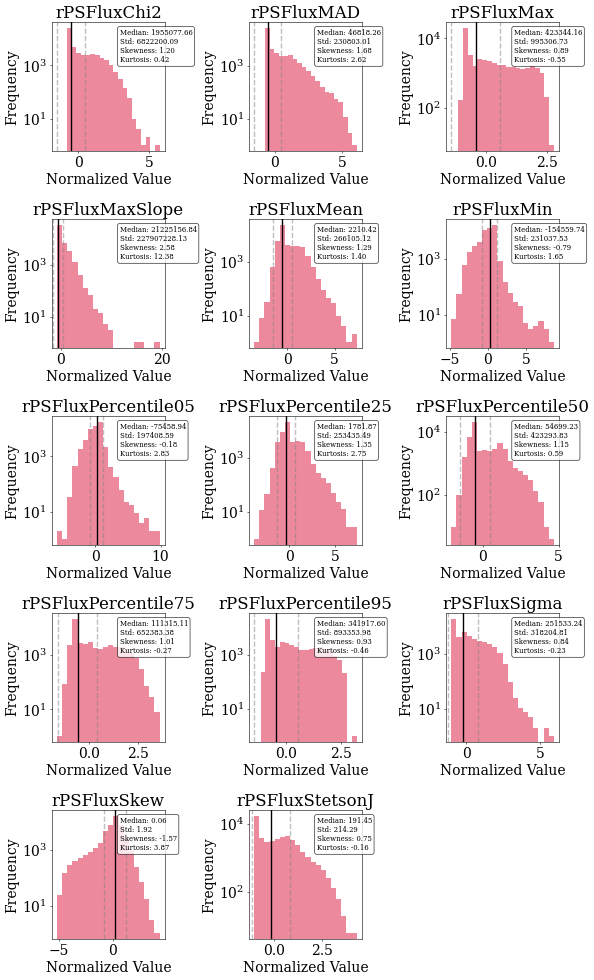

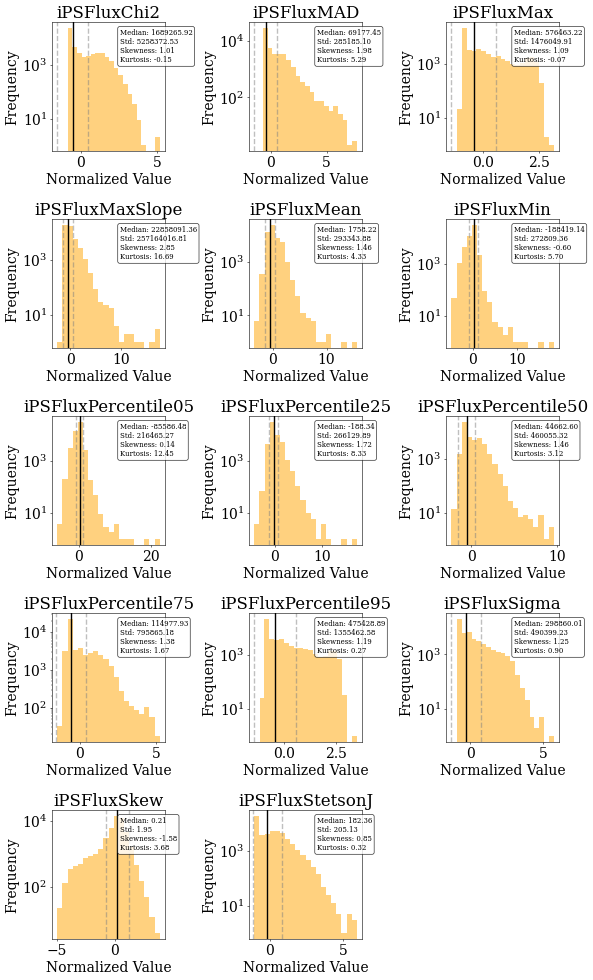

In [ ]:
clrs = ['teal', 'seagreen', 'crimson', 'orange', 'orangered', 'saddlebrown']
flts = list('ugrizy')

for _clr, _flt in zip(clrs, flts):

    plot_distributions(table, flt=_flt, color=_clr)

overall no peculiarities with the time-series features reported. **need to expand more on the discussion**

## What about the Covariances and Correlations Existing Between the Features?

In [17]:
results = service.search("SELECT ra, decl, nDiaSources, diaObjectId, "
                         "uPSFluxNdata, gPSFluxNdata, rPSFluxNdata, iPSFluxNdata, zPSFluxNdata, yPSFluxNdata, "
                         "uPSFluxChi2, gPSFluxChi2, rPSFluxChi2, iPSFluxChi2, zPSFluxChi2, yPSFluxChi2, * "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                         f"CIRCLE('ICRS', {center_coords}, {2})) = 1 "
                        "AND uPSFluxNdata > 0"
                        "AND gPSFluxNdata > 0"
                        "AND rPSFluxNdata > 0"
                        "AND iPSFluxNdata > 0"
                        "AND zPSFluxNdata > 0"
                        "AND yPSFluxNdata > 0"
                        "AND uPSFluxChi2 > 0 "
                        "AND gPSFluxChi2 > 0 "
                        "AND rPSFluxChi2 > 0 "
                        "AND iPSFluxChi2 > 0 "
                        "AND zPSFluxChi2 > 0 "
                        "AND yPSFluxChi2 > 0 ")

table = results.to_table()

In [18]:
import seaborn as sns
from scipy.stats import pearsonr

def plot_correlation_heatmap(data_table, flt='r'):
    """Plots a heatmap of correlation coefficients for each pair of columns in the data table."""
    # Get the columns from the astropy table
    columns = [
    'PSFluxChi2', 
    'PSFluxMAD',
    'PSFluxMax', 
    'PSFluxMaxSlope',
    'PSFluxMean',
    'PSFluxMin', 
    'PSFluxPercentile05',
    'PSFluxPercentile25', 
    'PSFluxPercentile50', 
    'PSFluxPercentile75', 
    'PSFluxPercentile95', 
    'PSFluxSigma', 
    'PSFluxSkew', 
    'PSFluxStetsonJ'
    ]
    columns = [flt + s for s in columns]

    # Extract the data from the astropy.table and convert to NumPy array
    data = np.array([data_table[column] for column in columns])

    # Remove rows containing NaN or inf values
    valid_indices = np.all(np.isfinite(data), axis=0)
    data = data[:, valid_indices]
    columns = [column for idx, column in enumerate(columns) if valid_indices[idx]]

    # Calculate the correlation matrix using scipy
    correlation_matrix = np.zeros((len(columns), len(columns)))
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            correlation_matrix[i, j], _ = pearsonr(data[i], data[j])

    # Create a heatmap using seaborn
    plt.figure(figsize=(20, 20))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=columns, yticklabels=columns)
    plt.title(f"Correlation Heatmap in LSST-{flt}")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

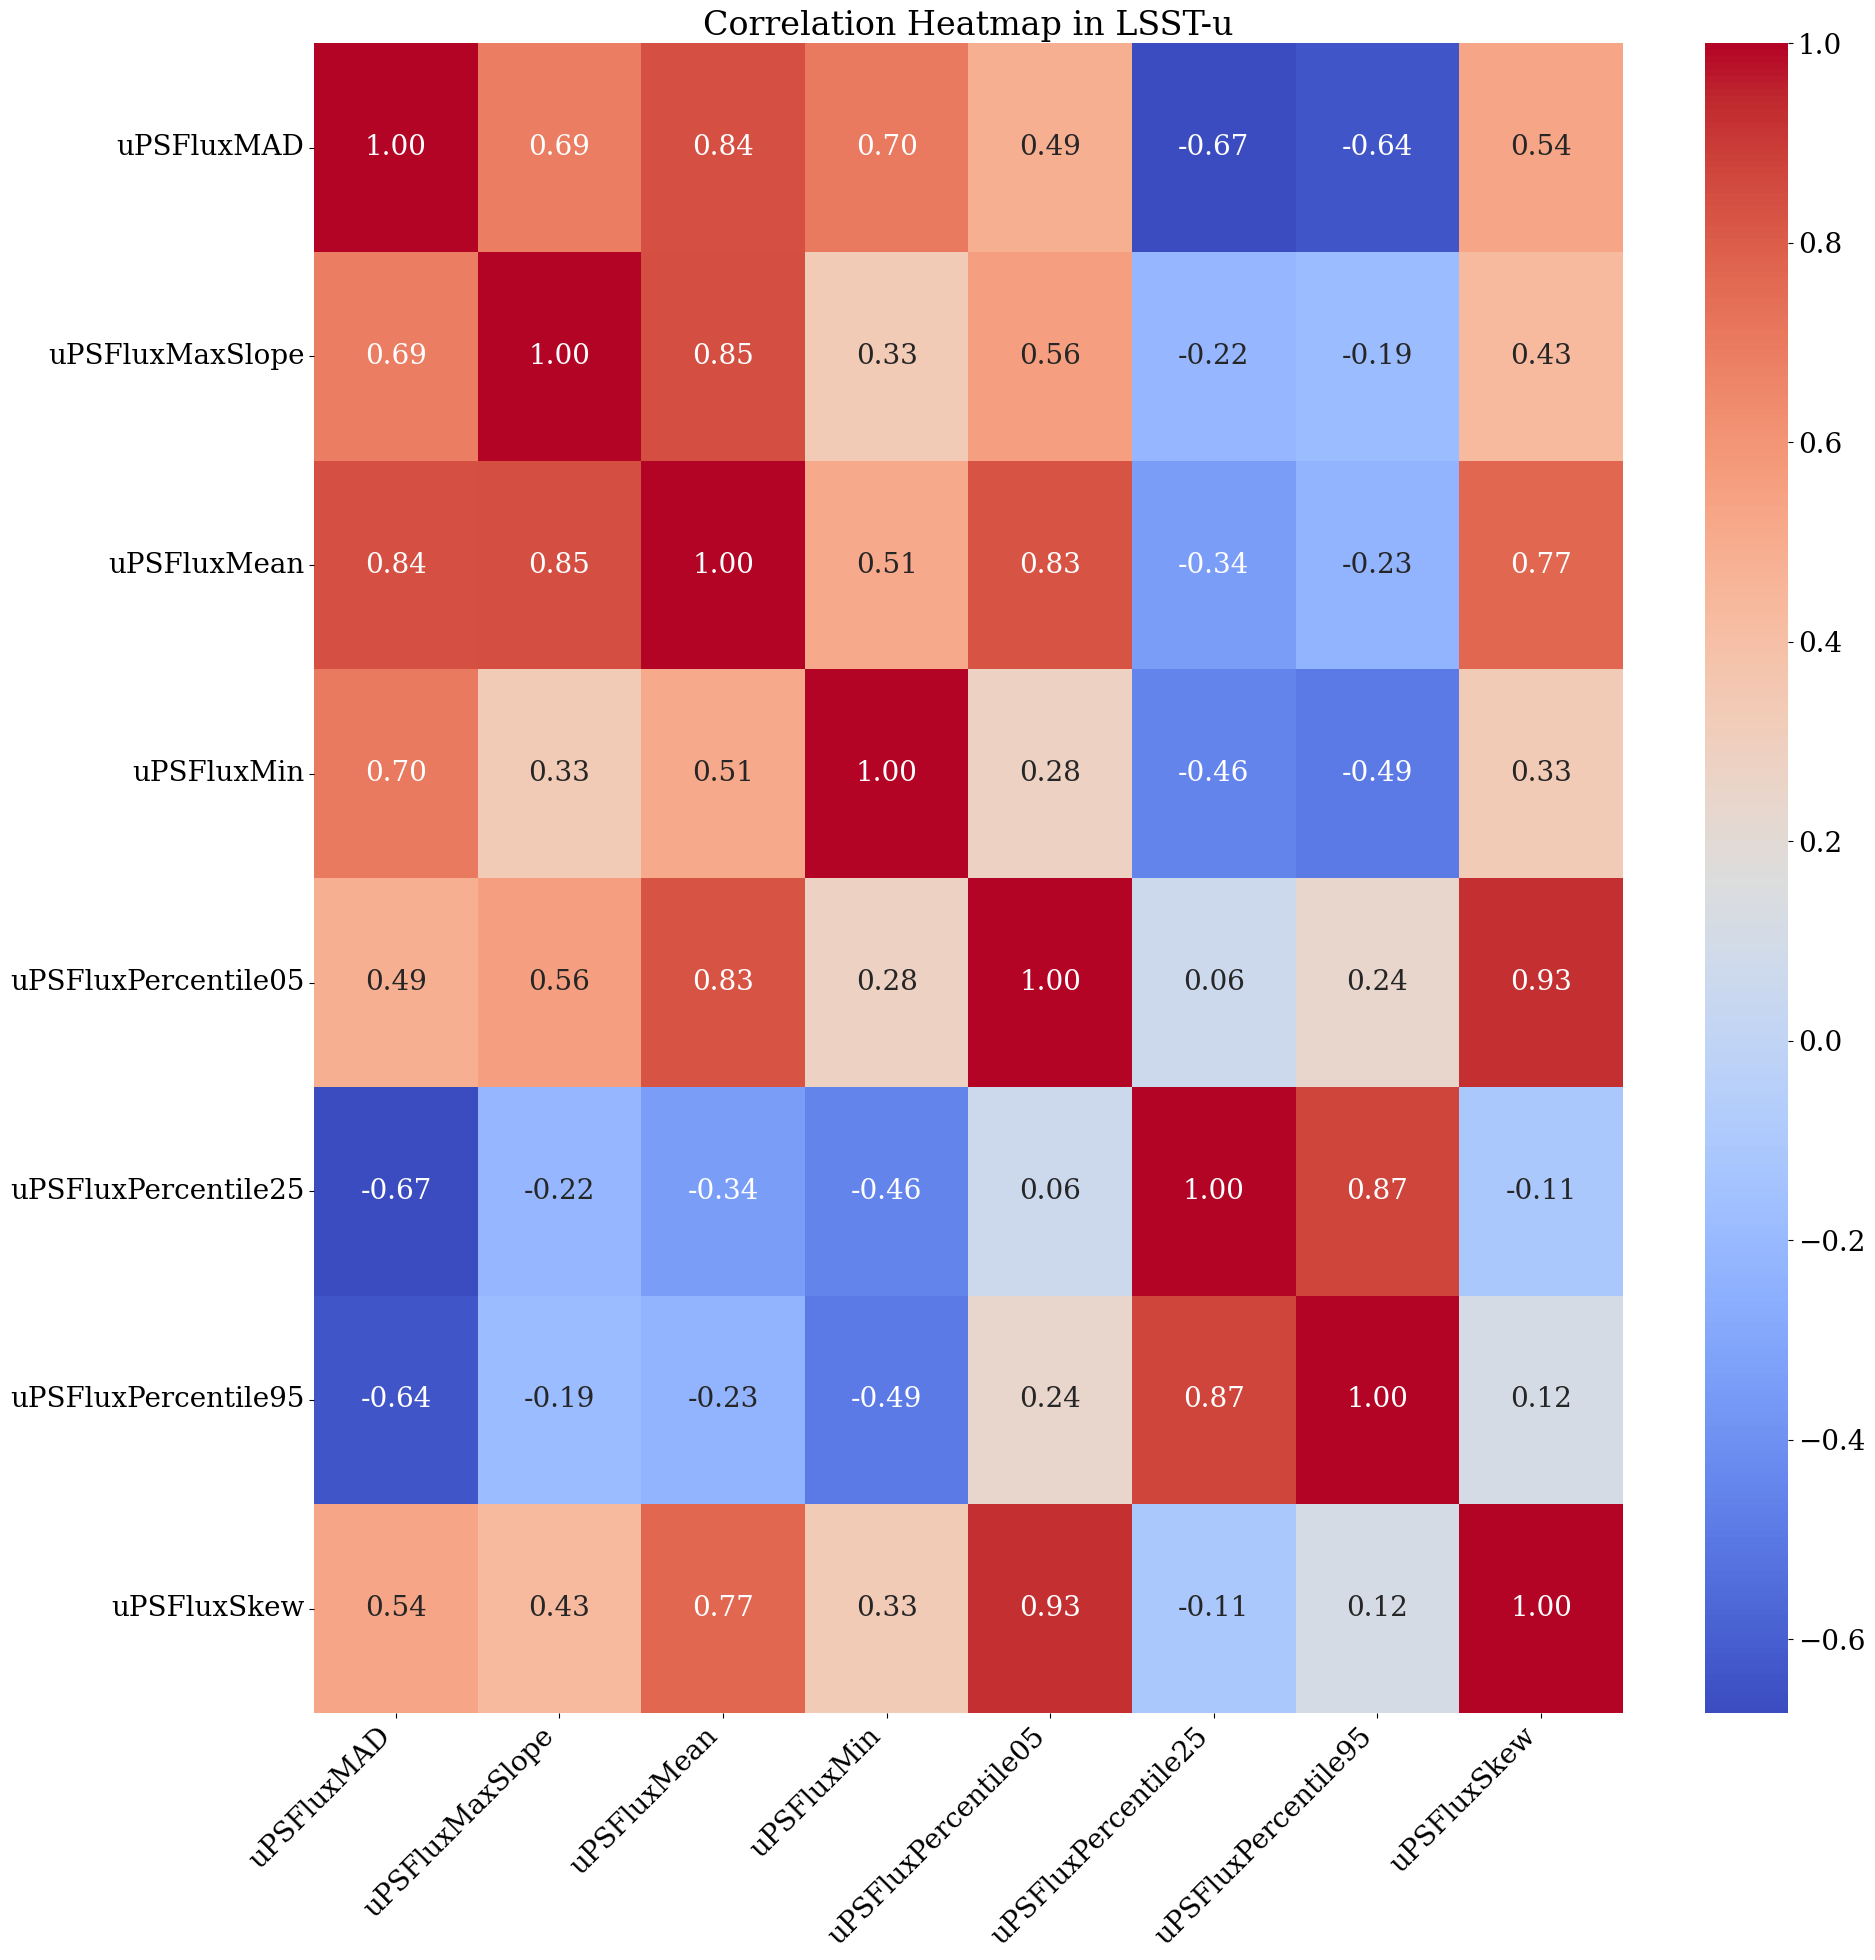

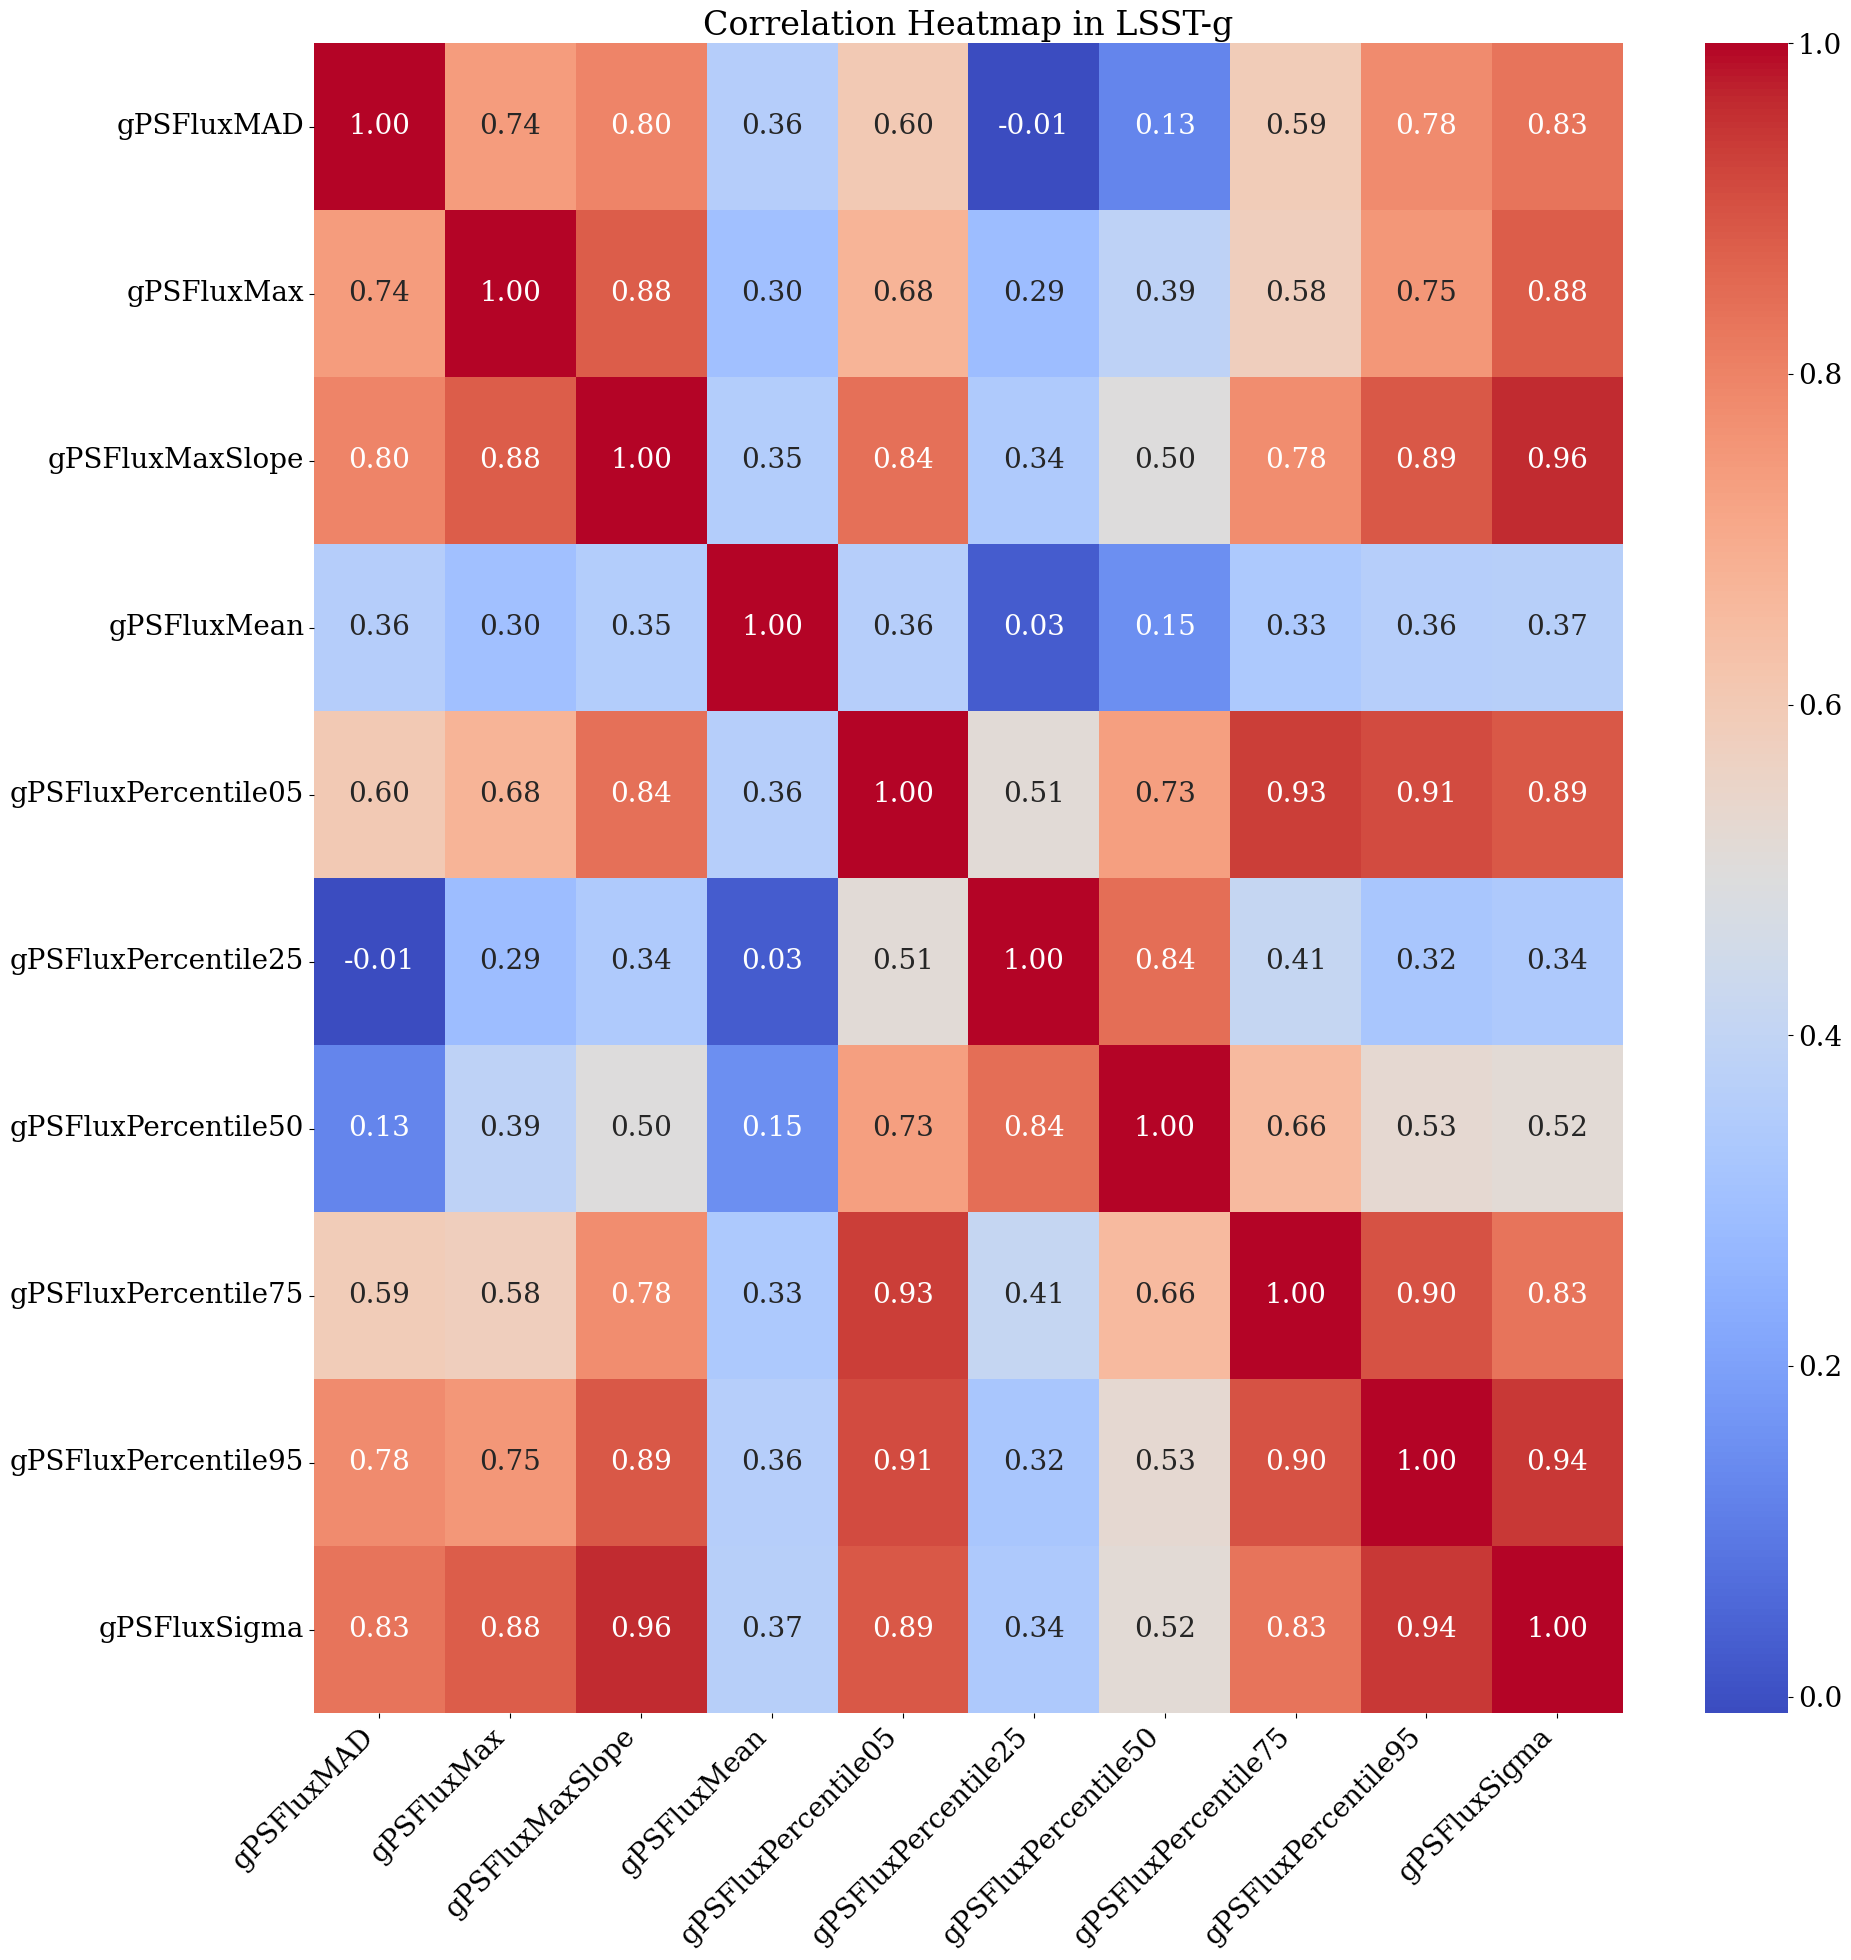

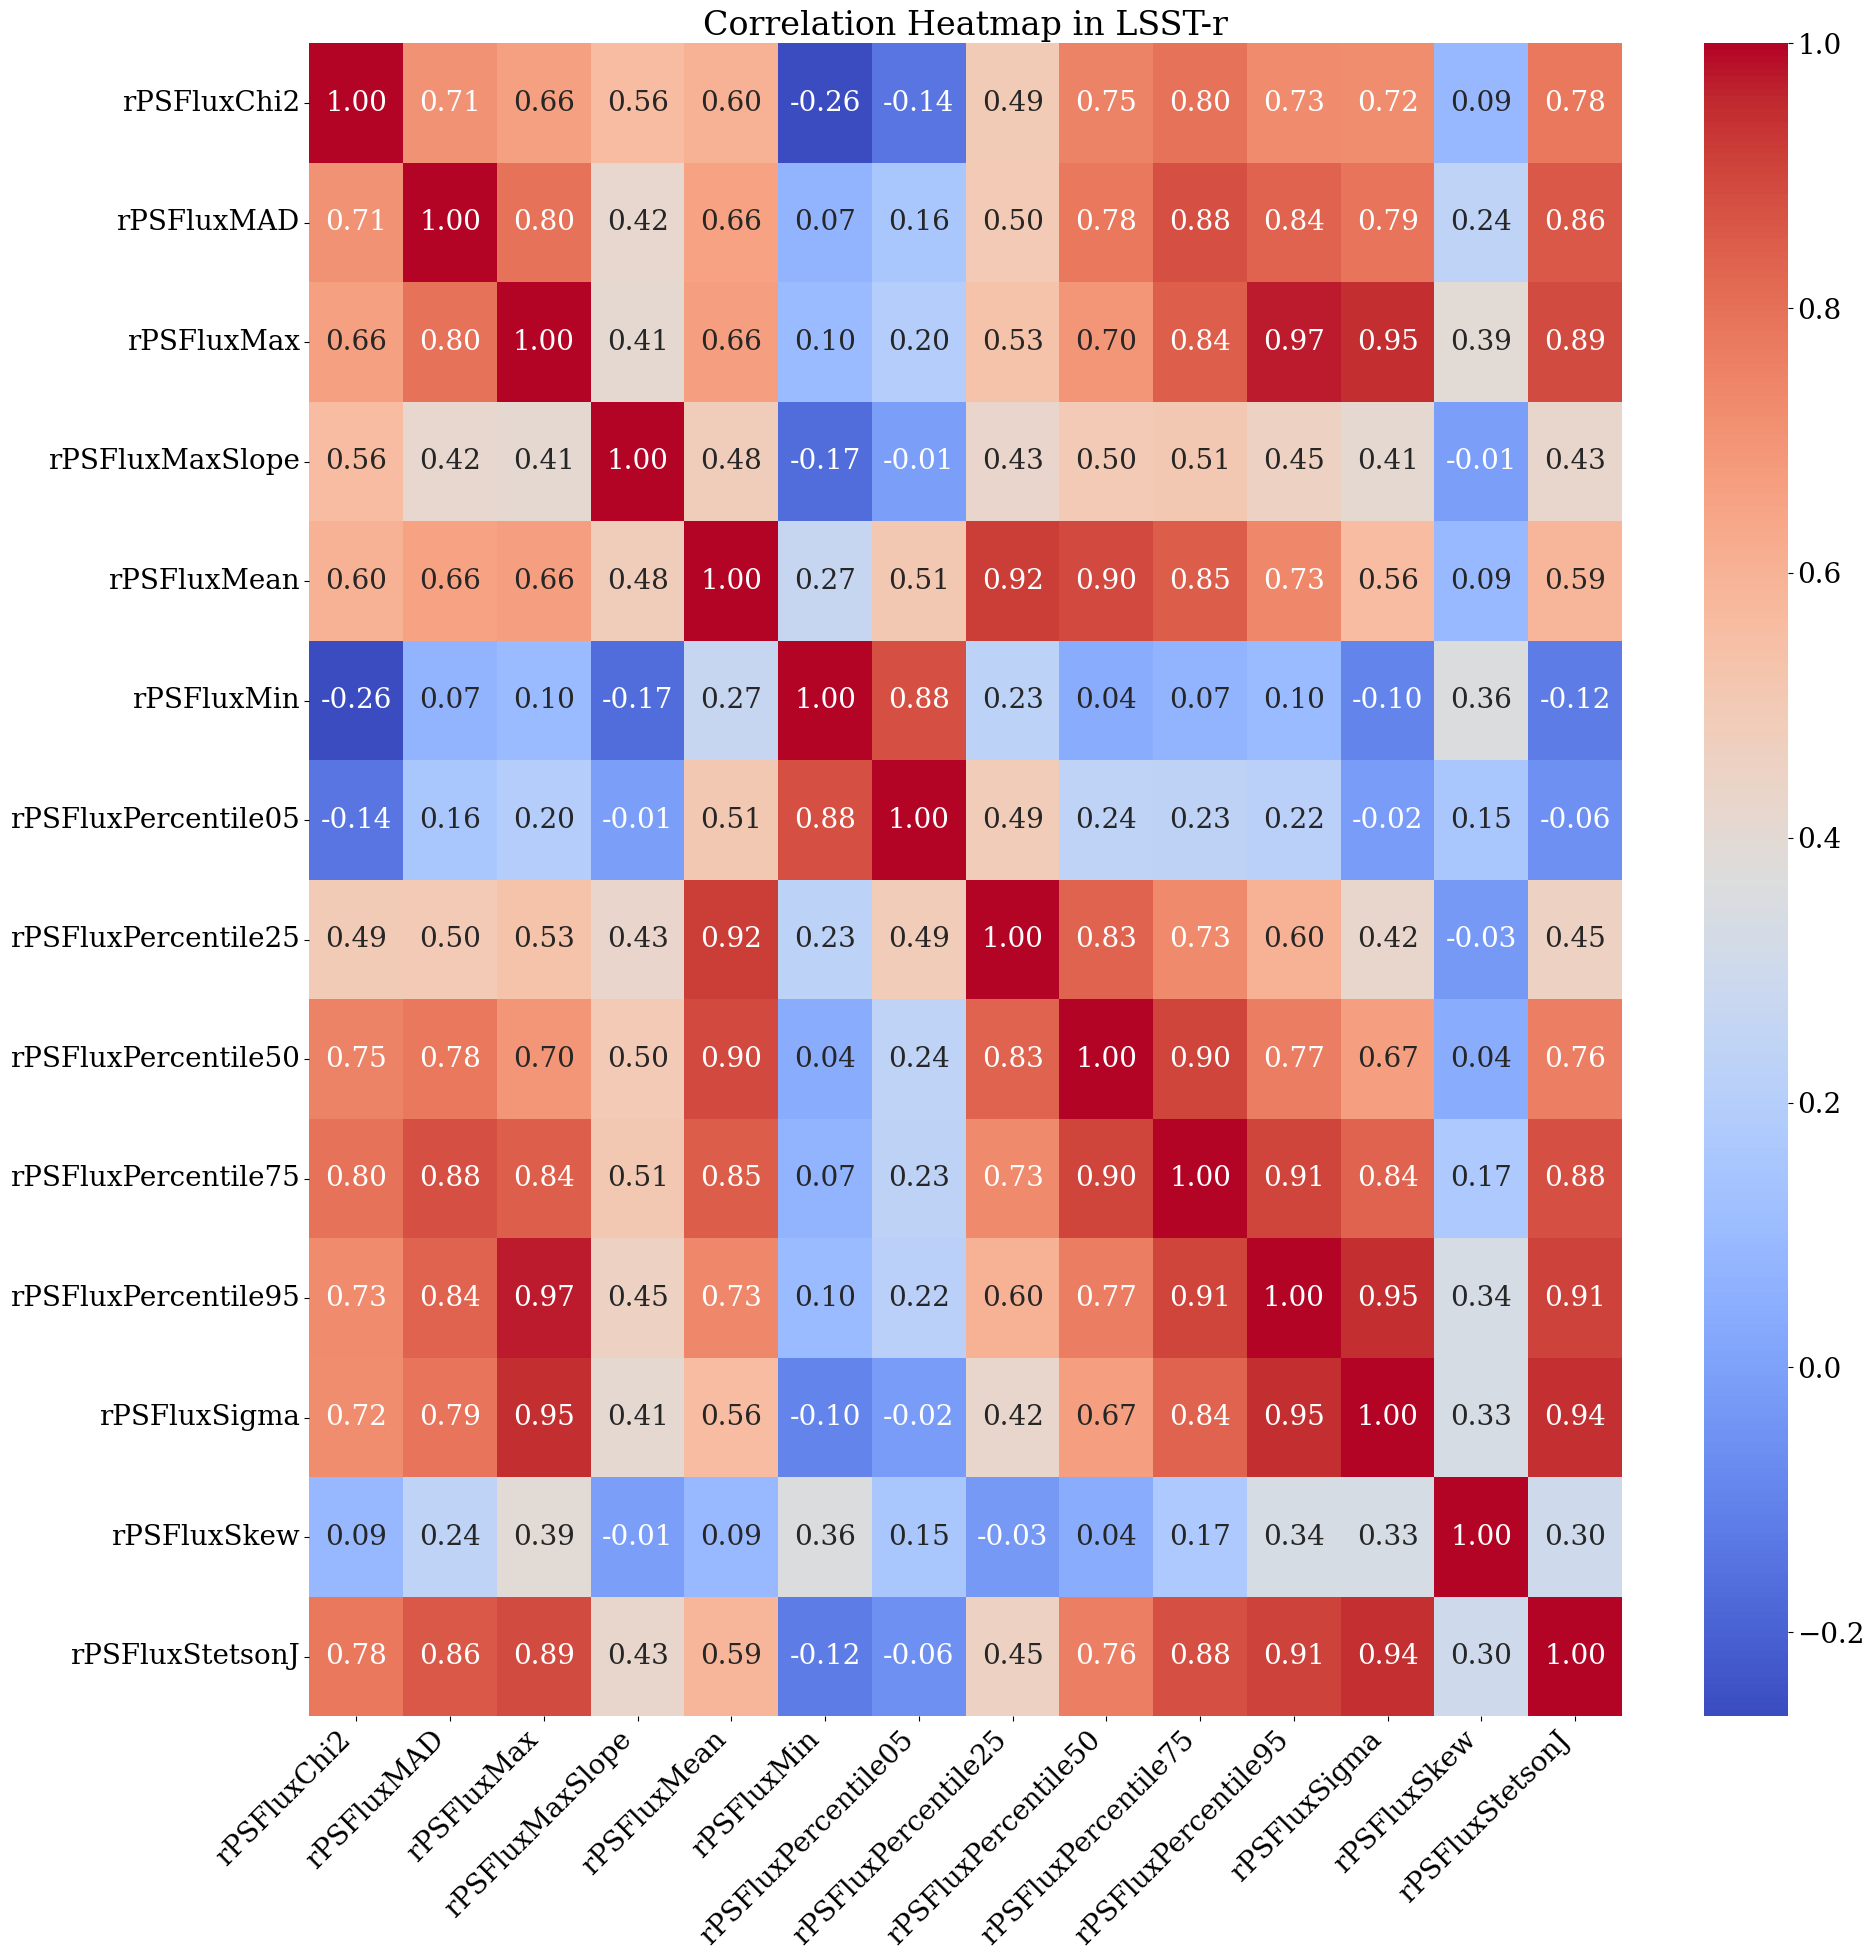

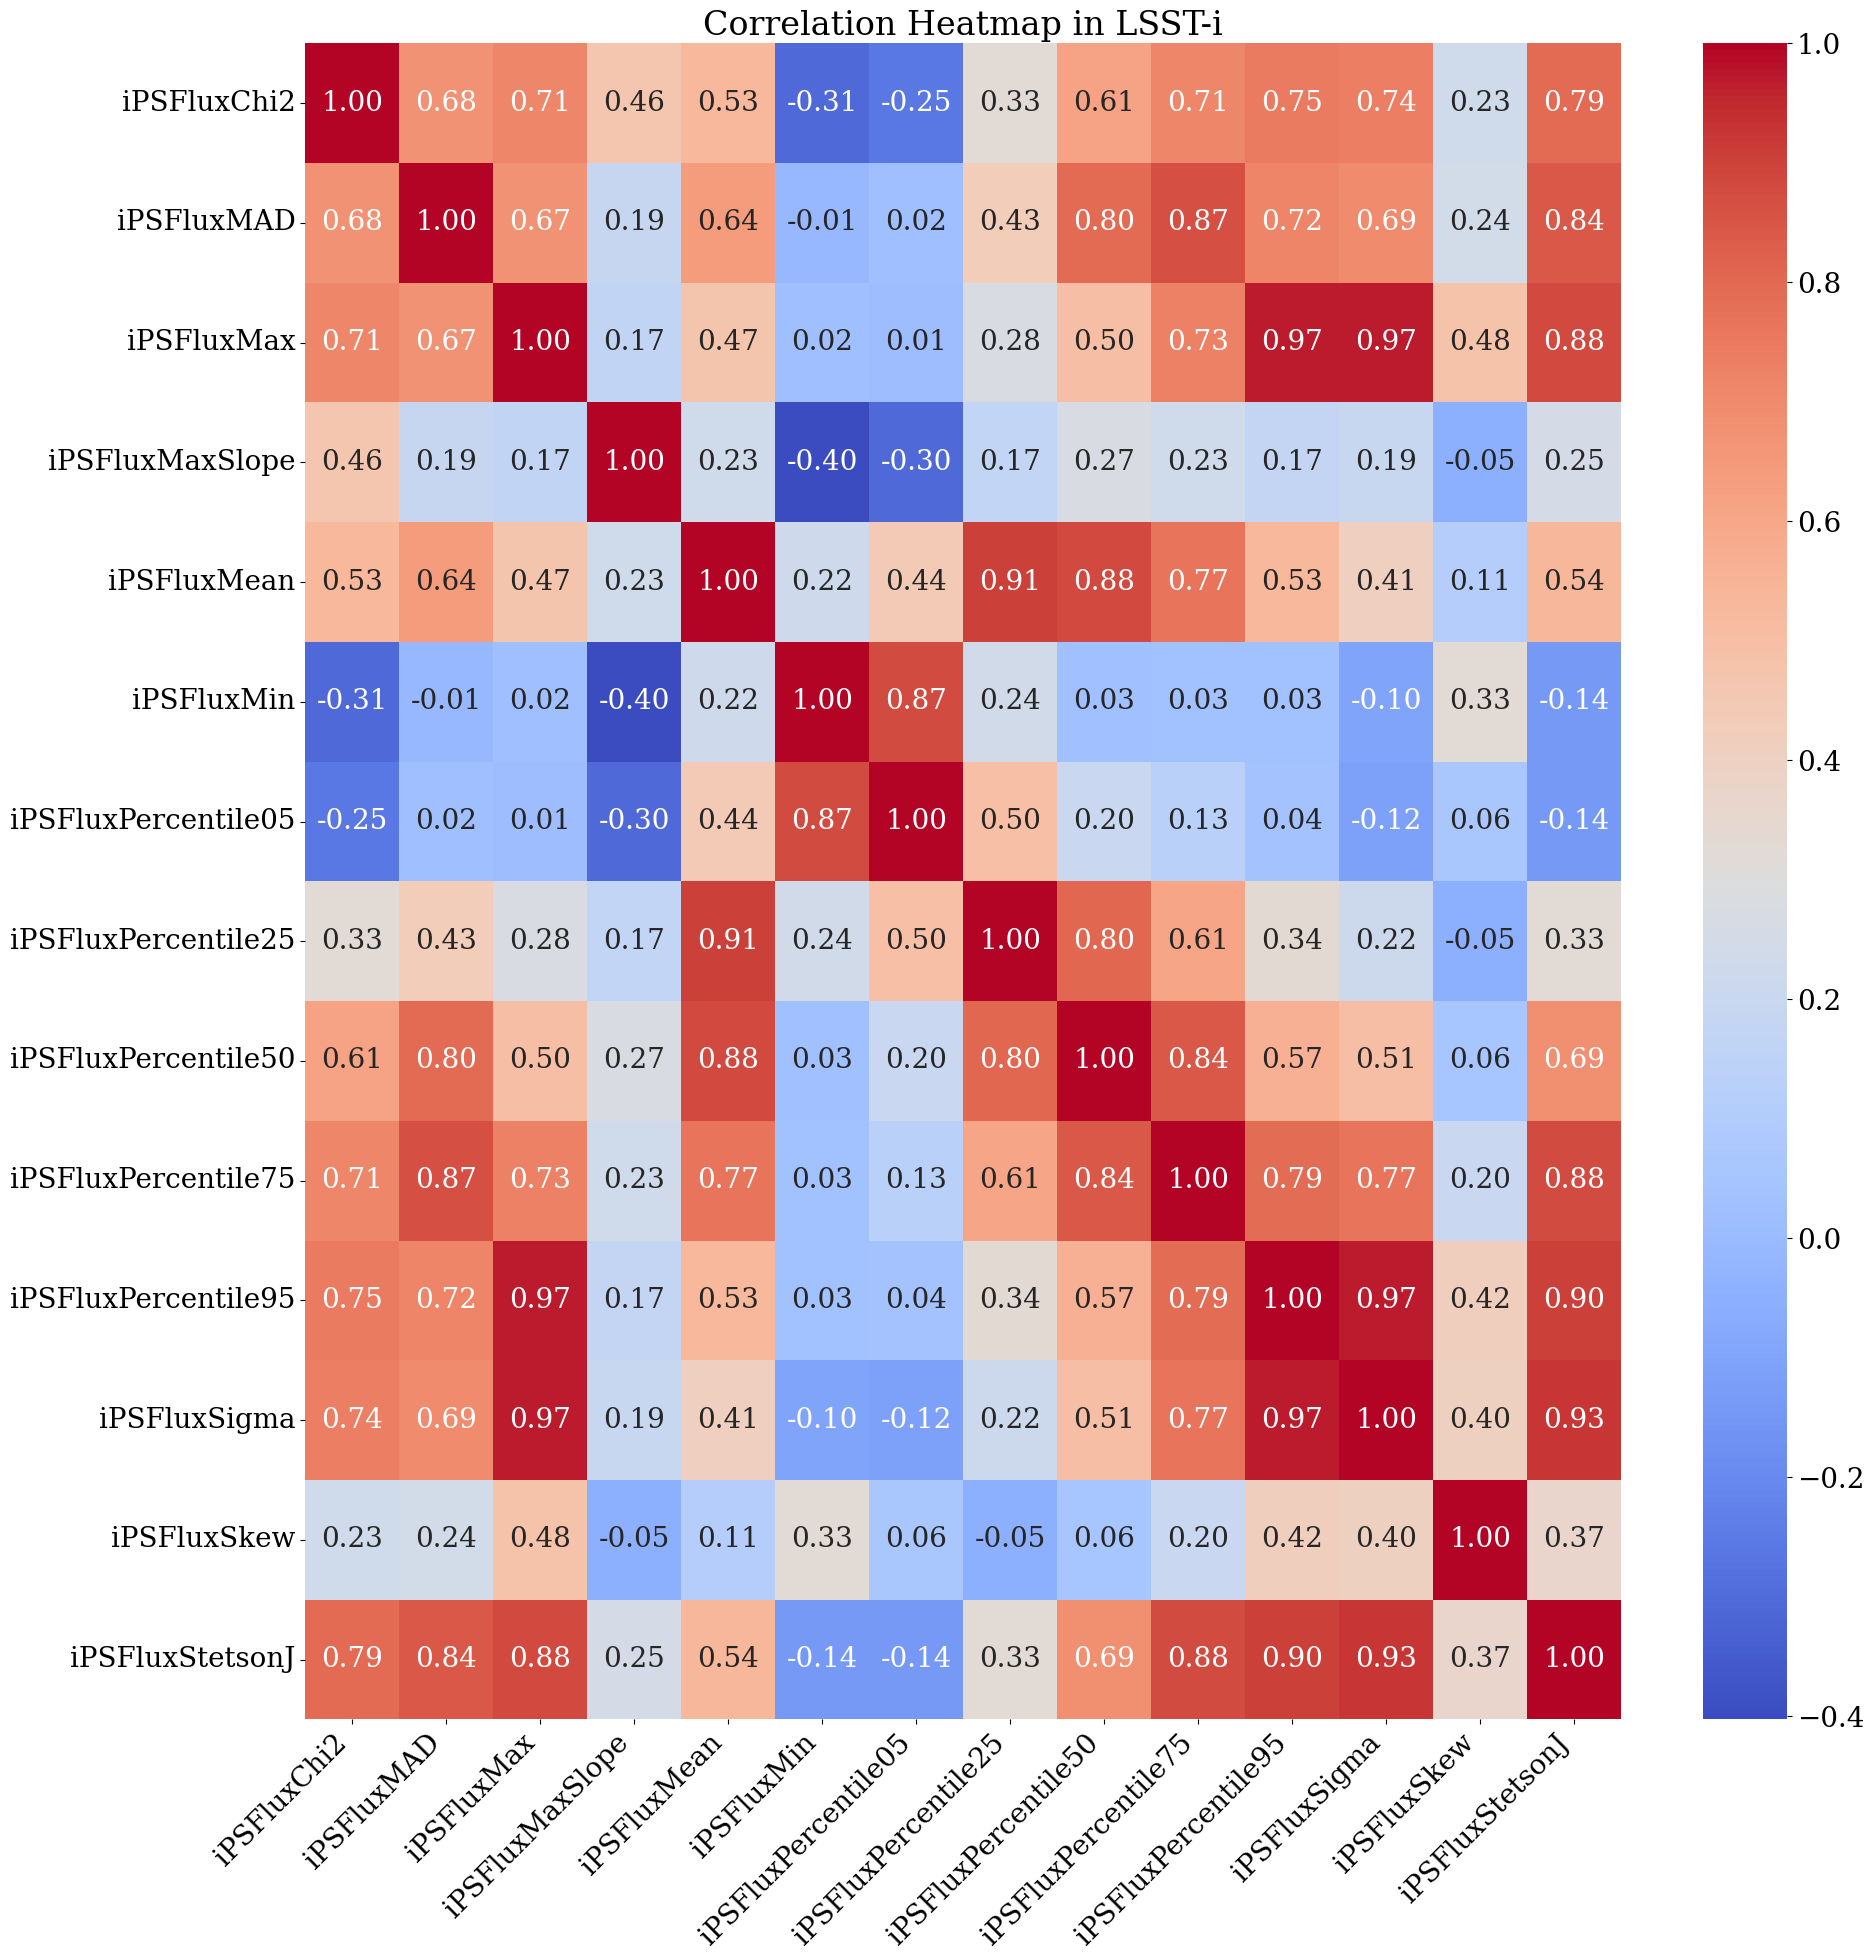

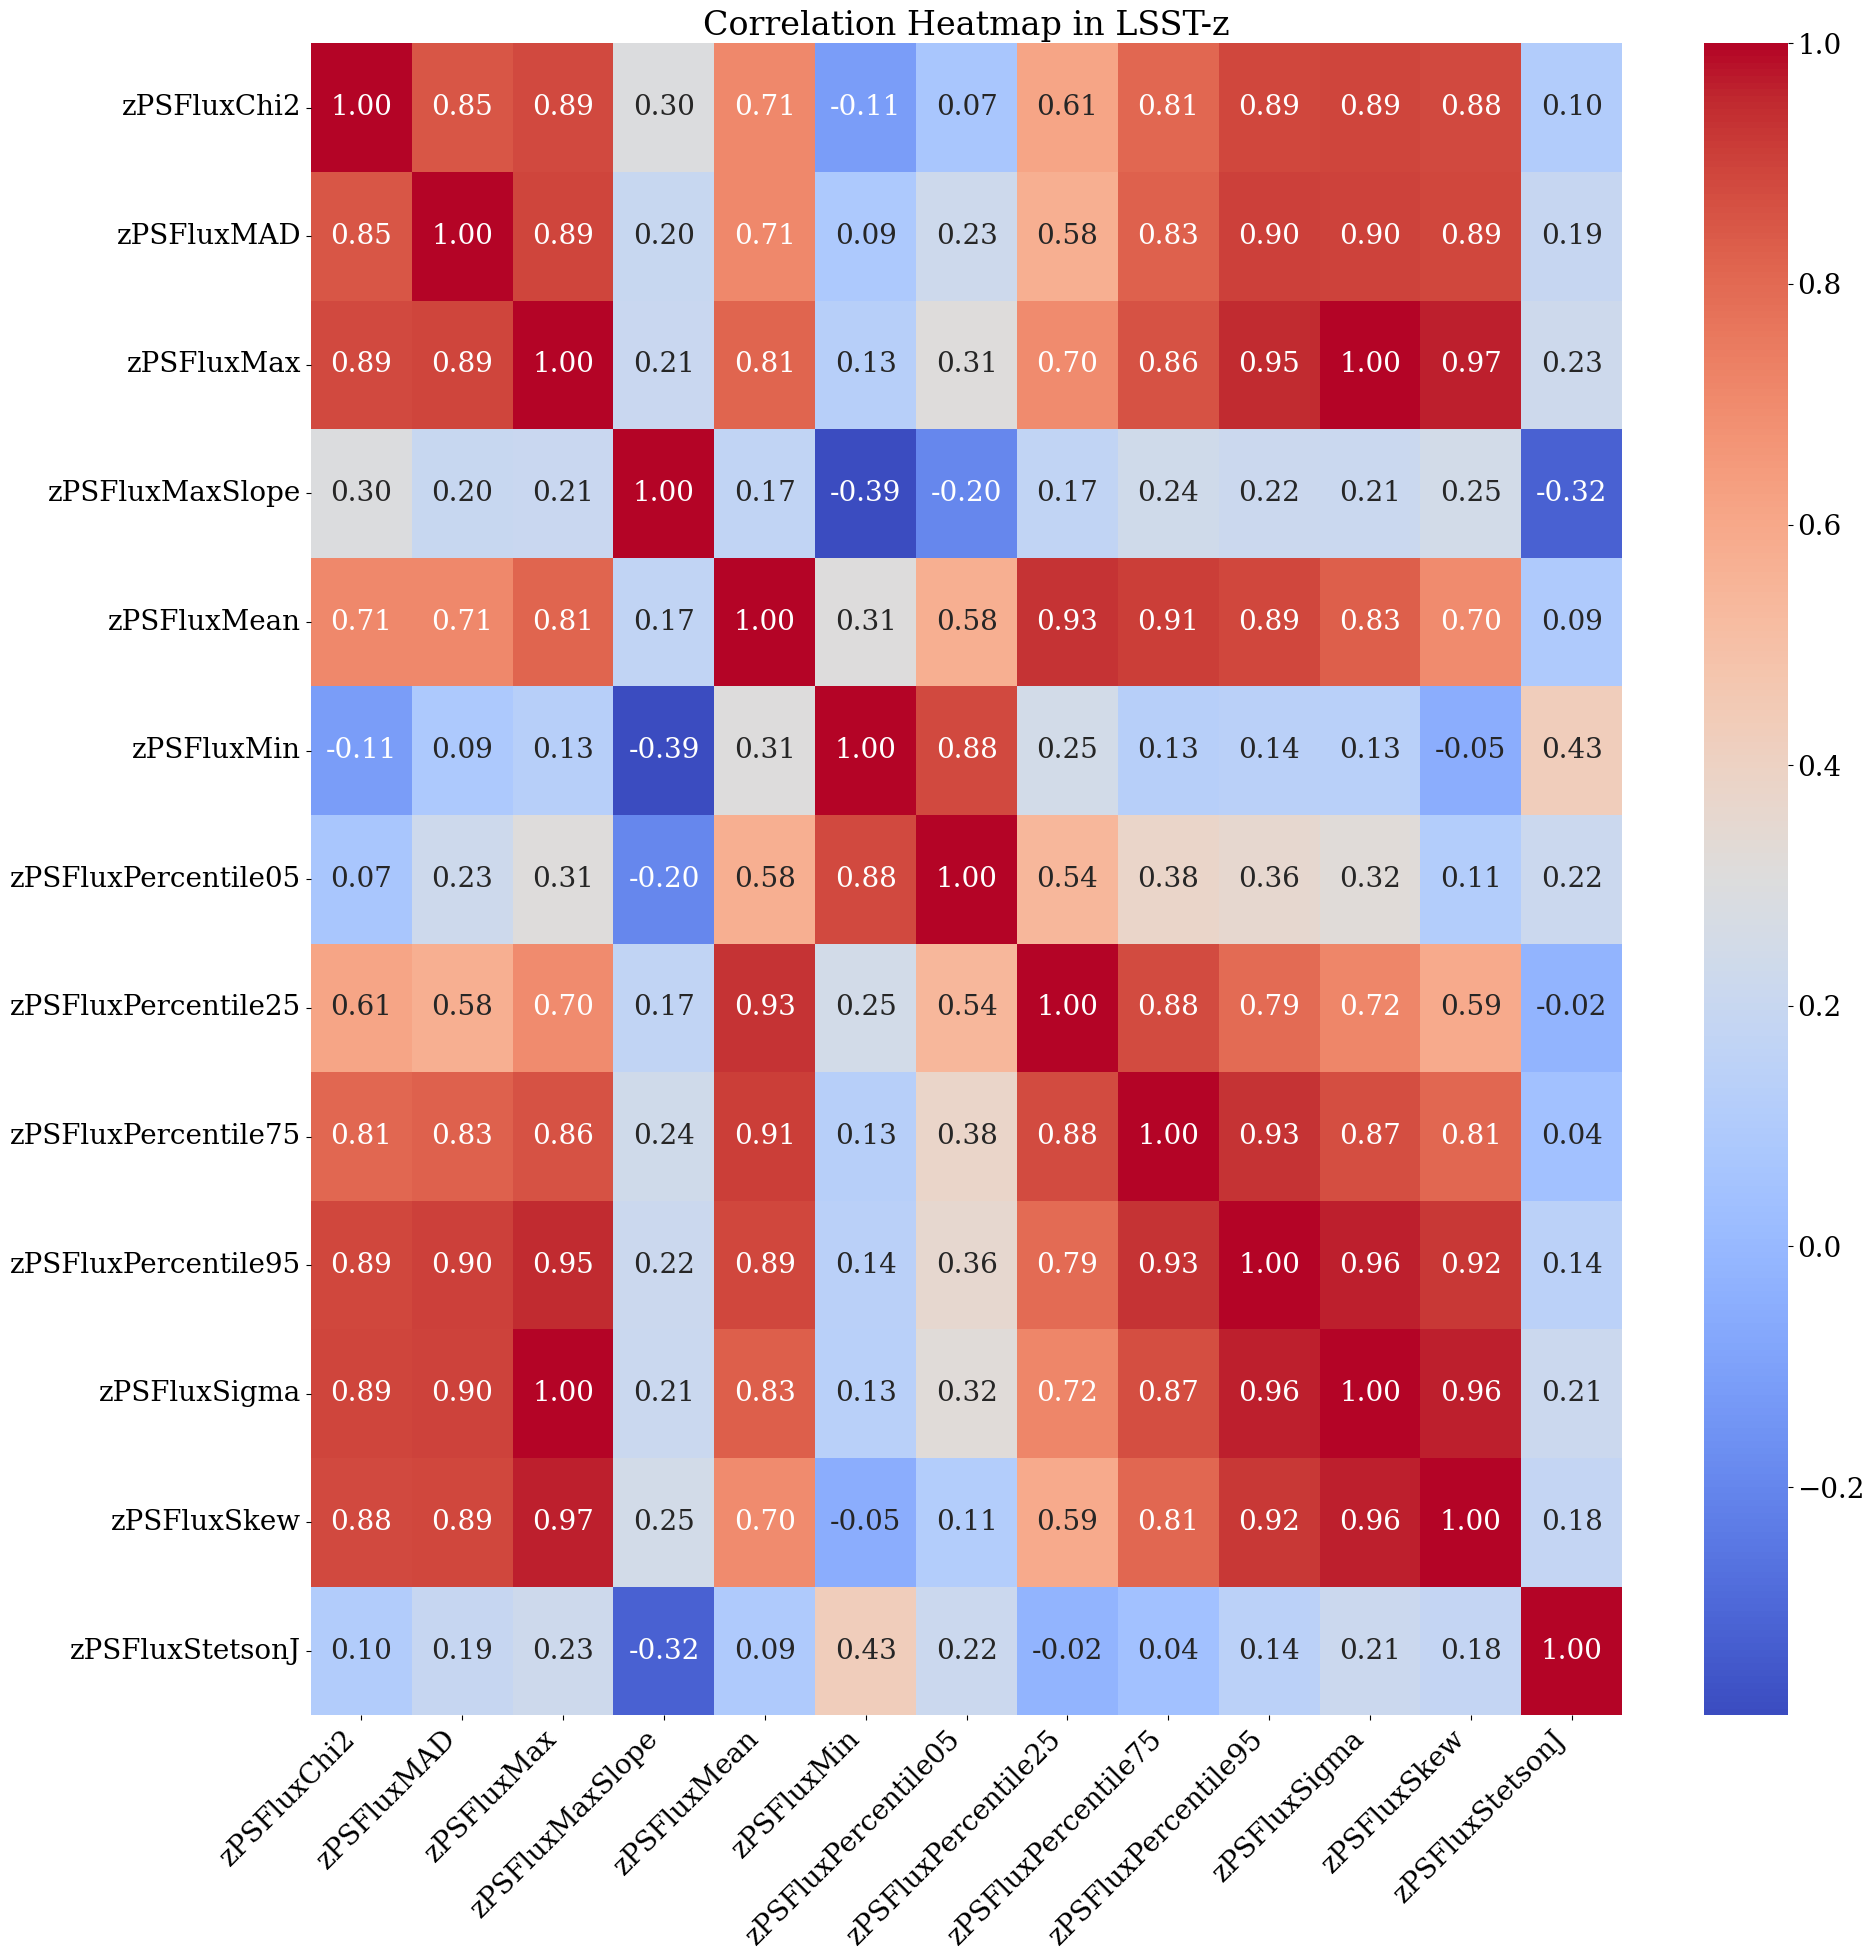

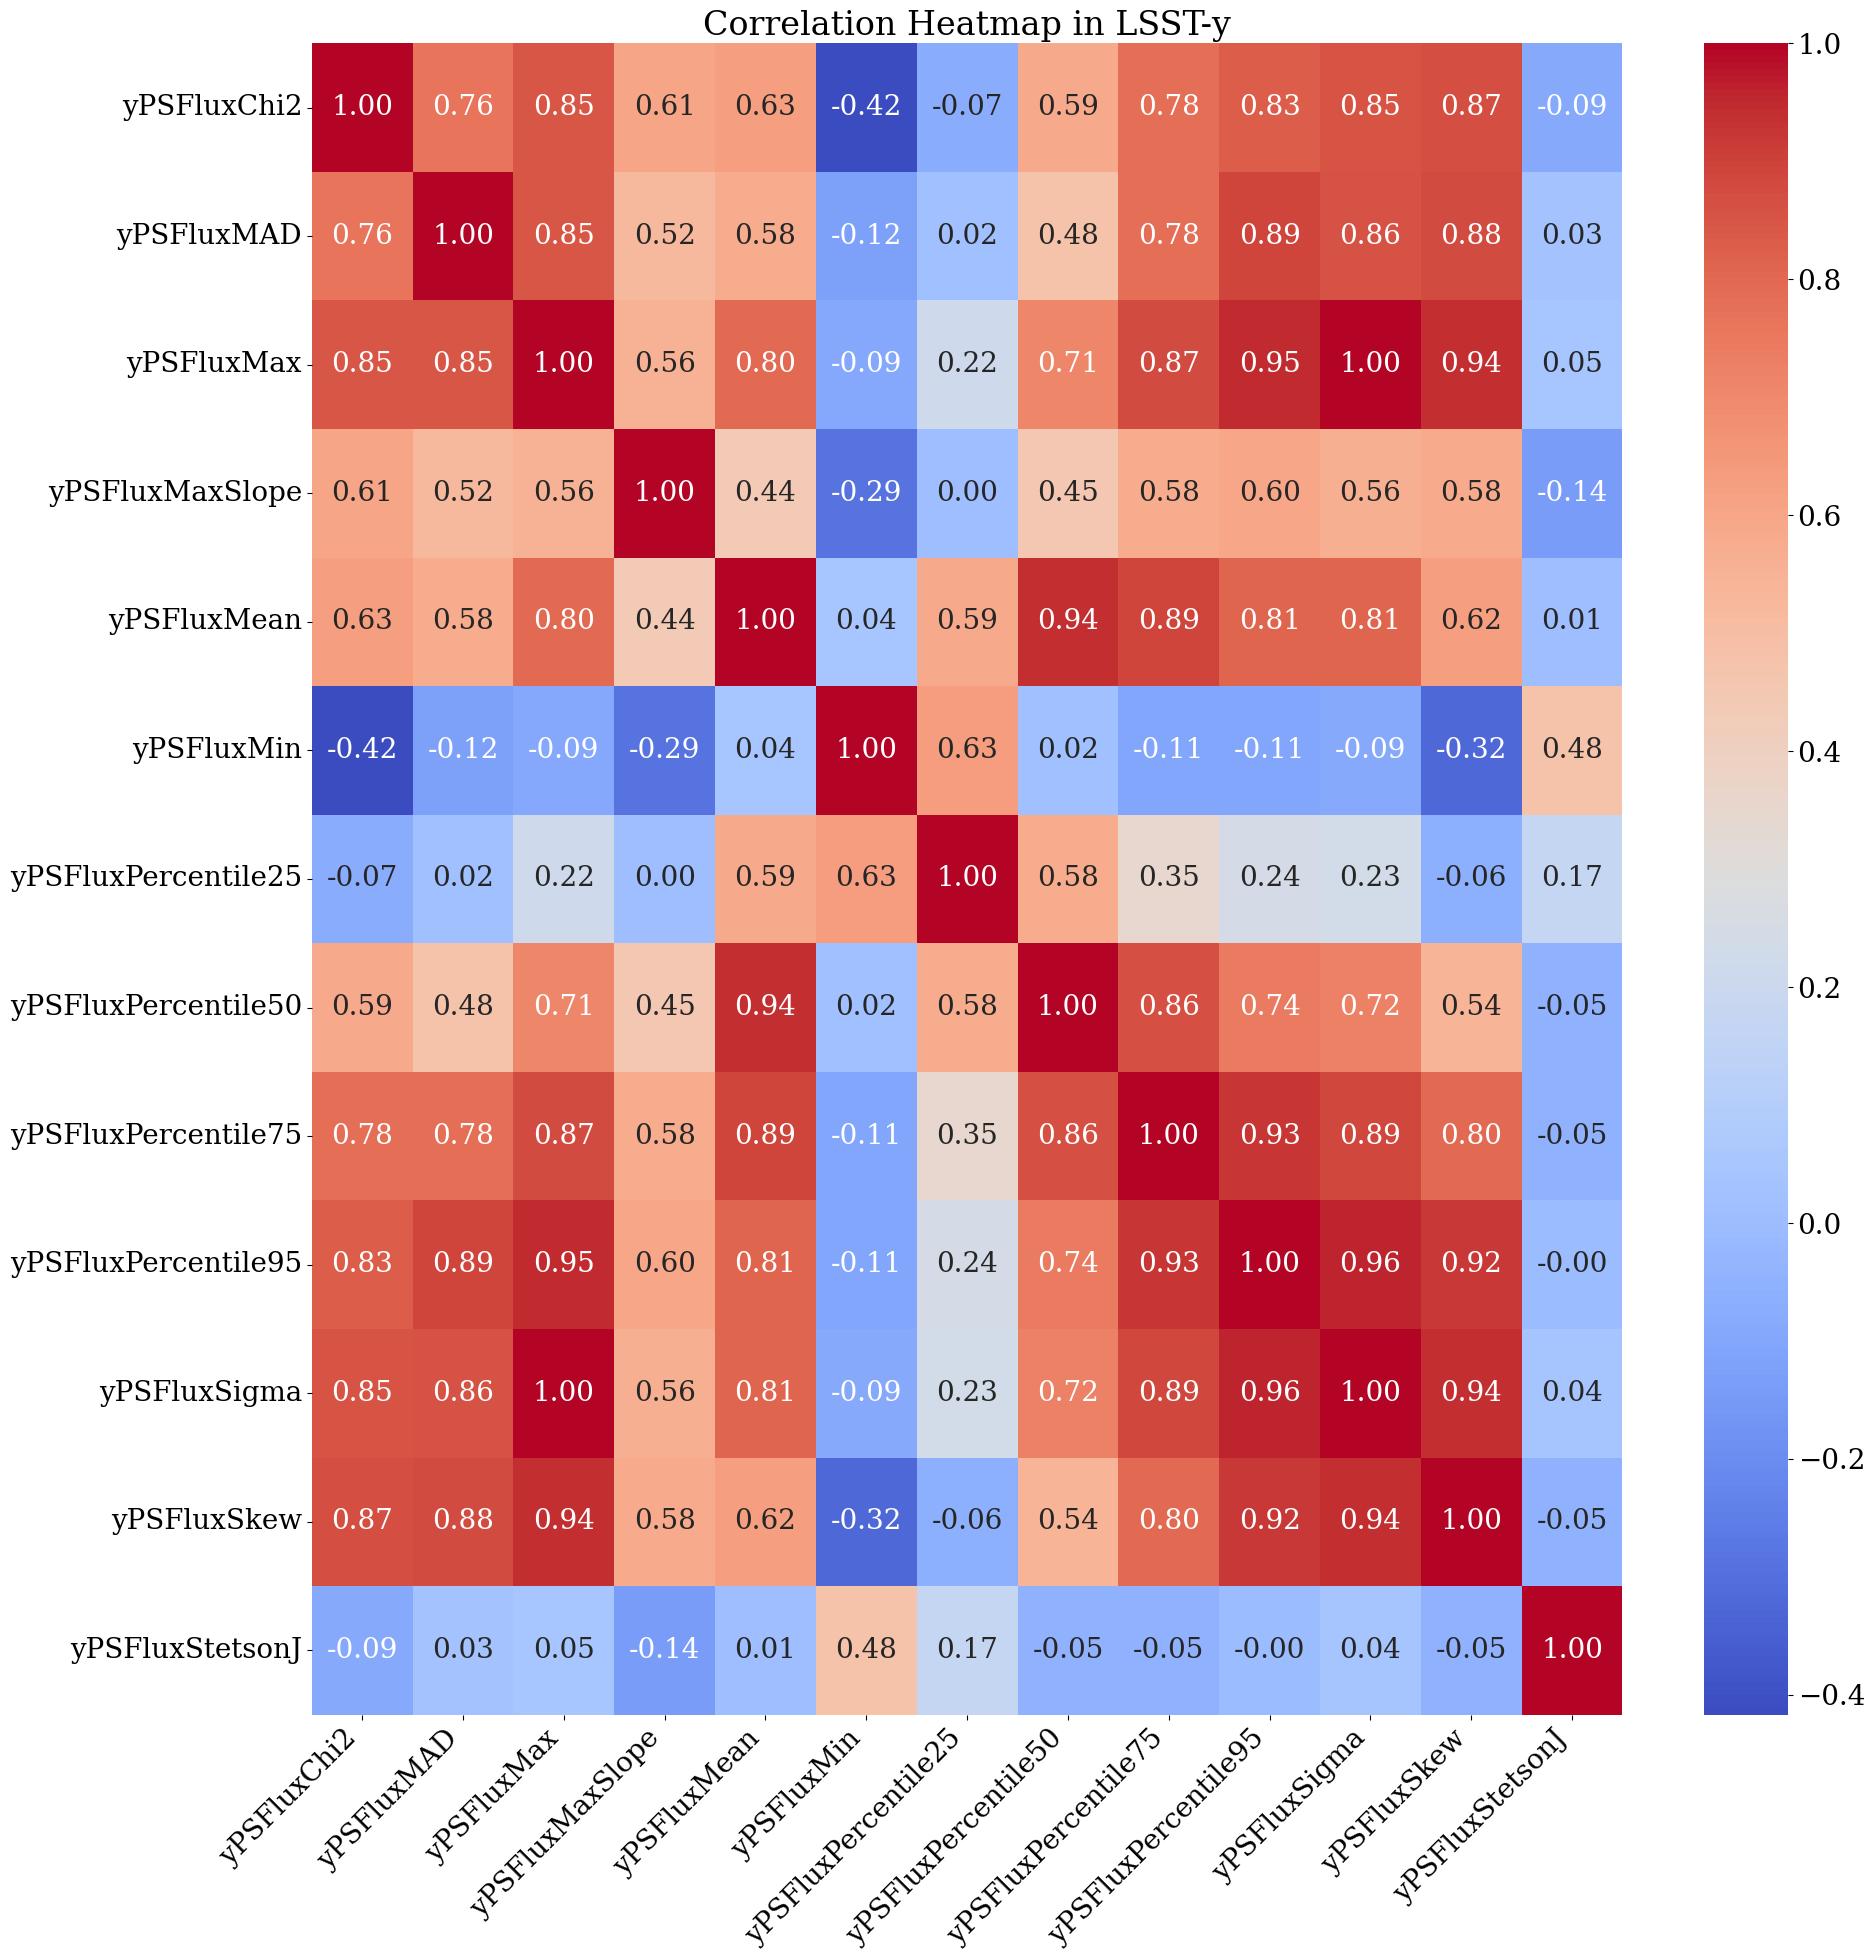

In [19]:
for ff in list('ugrizy'):
    plot_correlation_heatmap(table, flt=ff)

alternatively, we can also visualize this using biokit

In [20]:
def plot_biokit_corr(table, flt='u'):
    columns = [
    'PSFluxChi2', 
    'PSFluxMAD',
    'PSFluxMax', 
    'PSFluxMaxSlope',
    'PSFluxMean',
    'PSFluxMin', 
    'PSFluxPercentile05',
    'PSFluxPercentile25', 
    'PSFluxPercentile50', 
    'PSFluxPercentile75', 
    'PSFluxPercentile95', 
    'PSFluxSigma', 
    'PSFluxSkew', 
    'PSFluxStetsonJ'
    ]
    from biokit import corrplot
    columns = [flt + cols for cols in columns]
    
    table_sel = table[columns]
    data = table_sel.to_pandas()
    
    fig = plt.figure(figsize=(35, 20))

    c = corrplot.Corrplot(data.loc[:,columns])
    c.plot(fig, cmap='gist_stern_r')
    plt.title(f"LSST-{flt}", fontsize=35)


In [24]:
# plot... 
#plot_biokit_corr(table, flt='u')
#plot_biokit_corr(table, flt='g')
#plot_biokit_corr(table, flt='r')
#plot_biokit_corr(table, flt='i')
#plot_biokit_corr(table, flt='z')
#plot_biokit_corr(table, flt='y')

## Checking for Signal-Error

In [22]:
# we will expand the search radius of our table to ~5deg
results = service.search("SELECT ra, decl, nDiaSources, diaObjectId, "
                         "uPSFluxNdata, gPSFluxNdata, rPSFluxNdata, iPSFluxNdata, zPSFluxNdata, yPSFluxNdata, "
                         "uPSFluxChi2, gPSFluxChi2, rPSFluxChi2, iPSFluxChi2, zPSFluxChi2, yPSFluxChi2, * "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE CONTAINS(POINT('ICRS', ra, decl), "
                         f"CIRCLE('ICRS', {center_coords}, {5})) = 1 "
                        "AND uPSFluxNdata > 0"
                        "AND gPSFluxNdata > 0"
                        "AND rPSFluxNdata > 0"
                        "AND iPSFluxNdata > 0"
                        "AND zPSFluxNdata > 0"
                        "AND yPSFluxNdata > 0"
                        "AND uPSFluxChi2 > 0 "
                        "AND gPSFluxChi2 > 0 "
                        "AND rPSFluxChi2 > 0 "
                        "AND iPSFluxChi2 > 0 "
                        "AND zPSFluxChi2 > 0 "
                        "AND yPSFluxChi2 > 0 ")

table = results.to_table()

def make_plot_avg(table, bins=50, xvar='PSFluxMean', size=80):
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    for i, filter_name in enumerate(filters):
        ax = axs[i // 3, i % 3]

        # Create the 2D histogram using imshow
        H, xedges, yedges = np.histogram2d(table[f'{filter_name}{xvar}'], table[f'{filter_name}PSFluxSigma'], bins=bins)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        im = ax.imshow(H.T, cmap='Blues', origin='lower', extent=extent, aspect='auto', interpolation='gaussian')

        # Calculate the mean of {filter_name}PSFluxNdata for each bin
        x_centers = 0.5 * (xedges[1:] + xedges[:-1])
        y_centers = 0.5 * (yedges[1:] + yedges[:-1])
        mean_values = np.zeros((len(x_centers), len(y_centers)))

        for j in tqdm(range(len(x_centers))):
            for k in range(len(y_centers)):
                x_idx = np.digitize(table[f'{filter_name}{xvar}'], xedges)
                y_idx = np.digitize(table[f'{filter_name}PSFluxSigma'], yedges)
                mask = (x_idx == j + 1) & (y_idx == k + 1)
                if np.sum(mask) > 0:
                    mean_values[j, k] = np.mean(table[f'{filter_name}PSFluxNdata'][mask])

        # Plot the mean values as color-coded markers using scatter
        X, Y = np.meshgrid(x_centers, y_centers)
        sc = ax.scatter(X, Y, c=mean_values.T, cmap='inferno', s=size, edgecolors='black', lw=0.5, marker='s')

        # Set labels and title
        ax.set_xlabel(f'{filter_name}{xvar}', fontsize=15)
        ax.set_ylabel(f'{filter_name}PSFluxSigma')
        ax.set_title(f'LSST-{filter_name}')
        
        # Add an individual colorbar for each panel
        cbar = fig.colorbar(sc, ax=ax)
        cbar.set_label('Mean of PSFluxNdata')

    plt.tight_layout()
    plt.show()

100%|██████████| 30/30 [00:01<00:00, 21.57it/s]


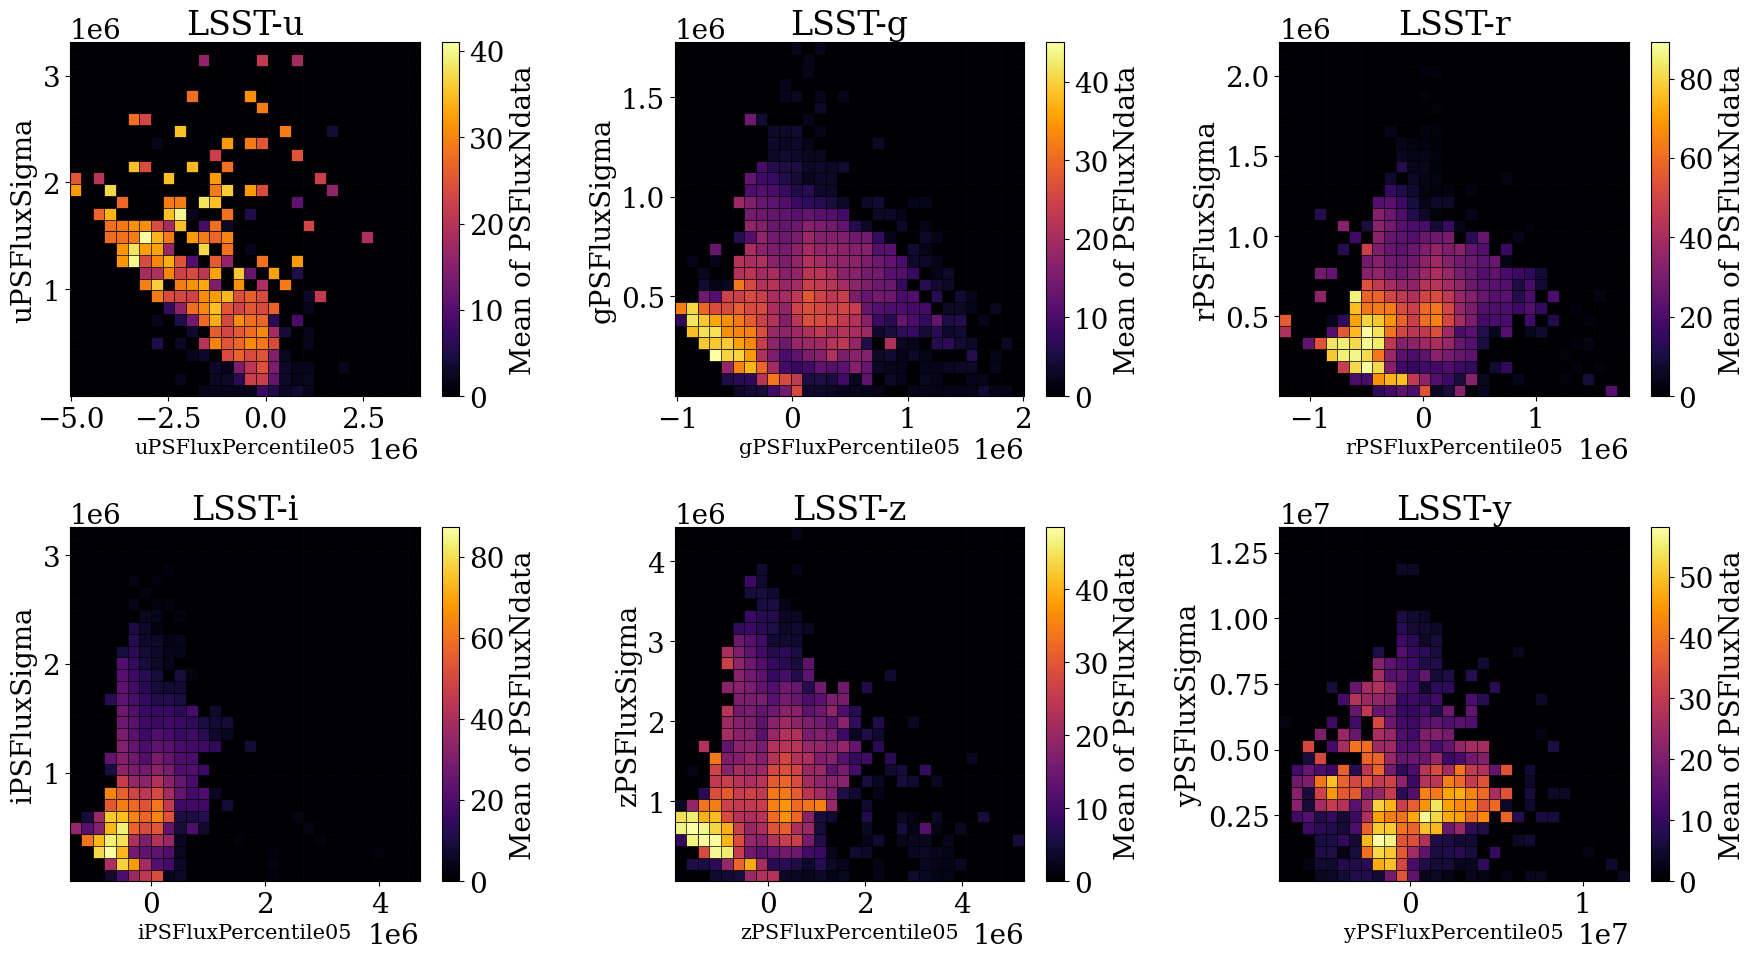

100%|██████████| 30/30 [00:01<00:00, 19.38it/s]


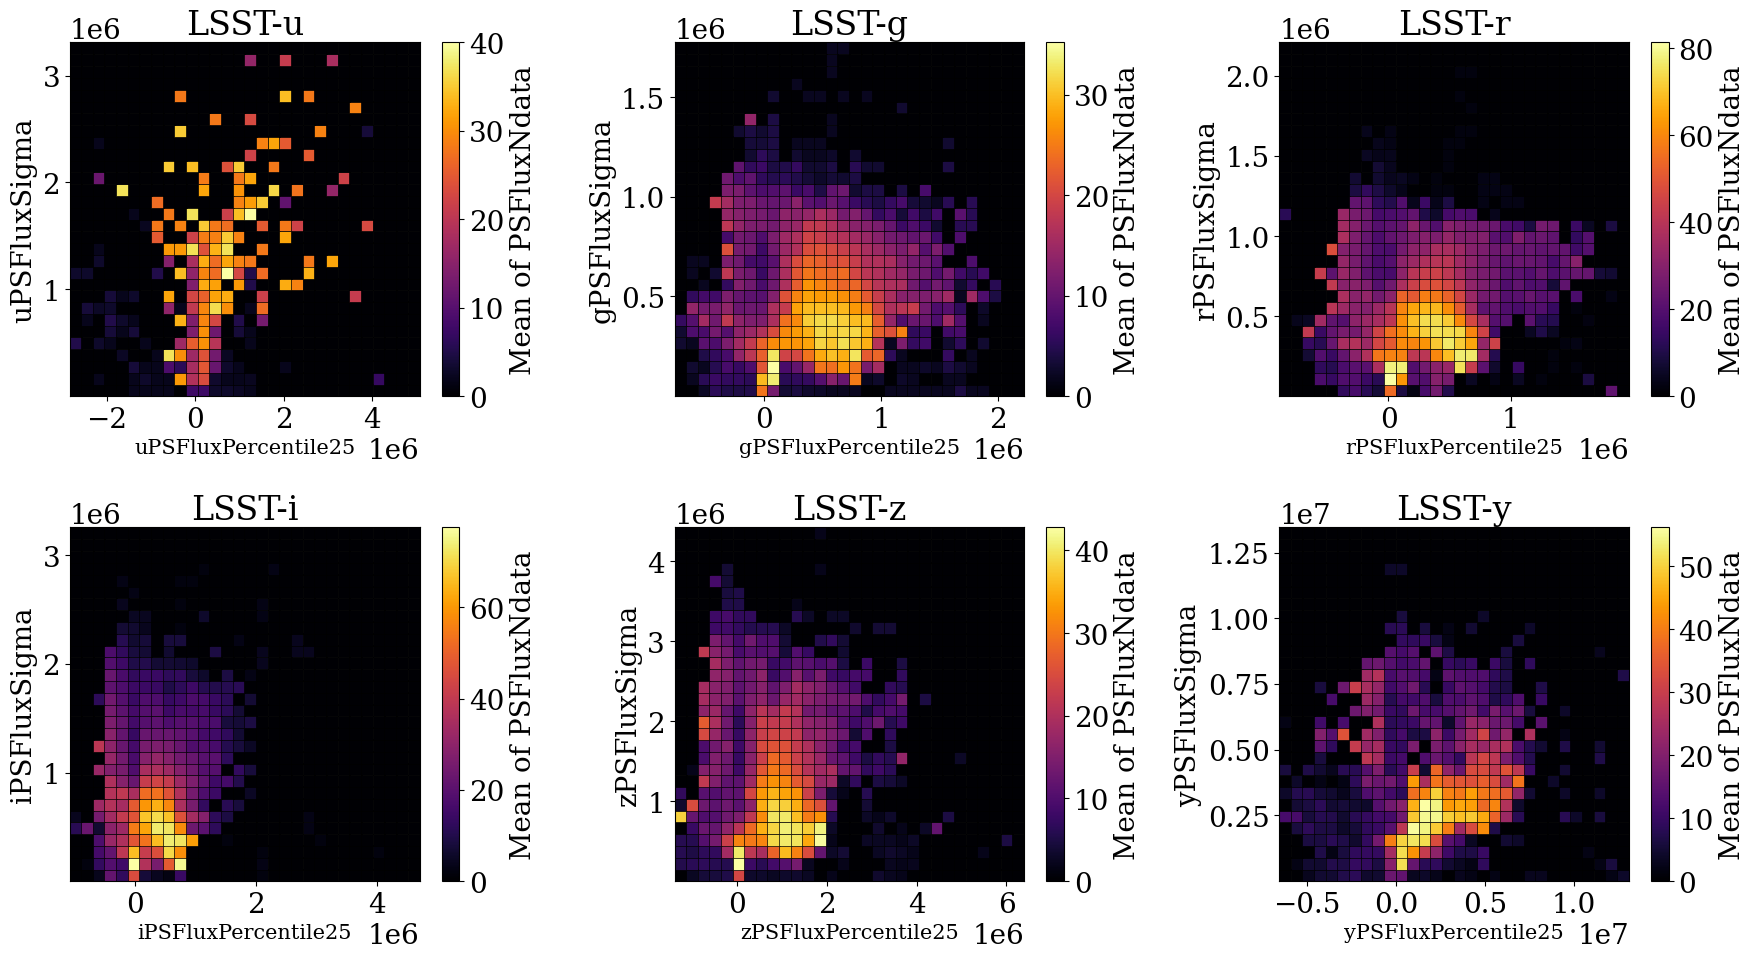

100%|██████████| 30/30 [00:01<00:00, 21.71it/s]


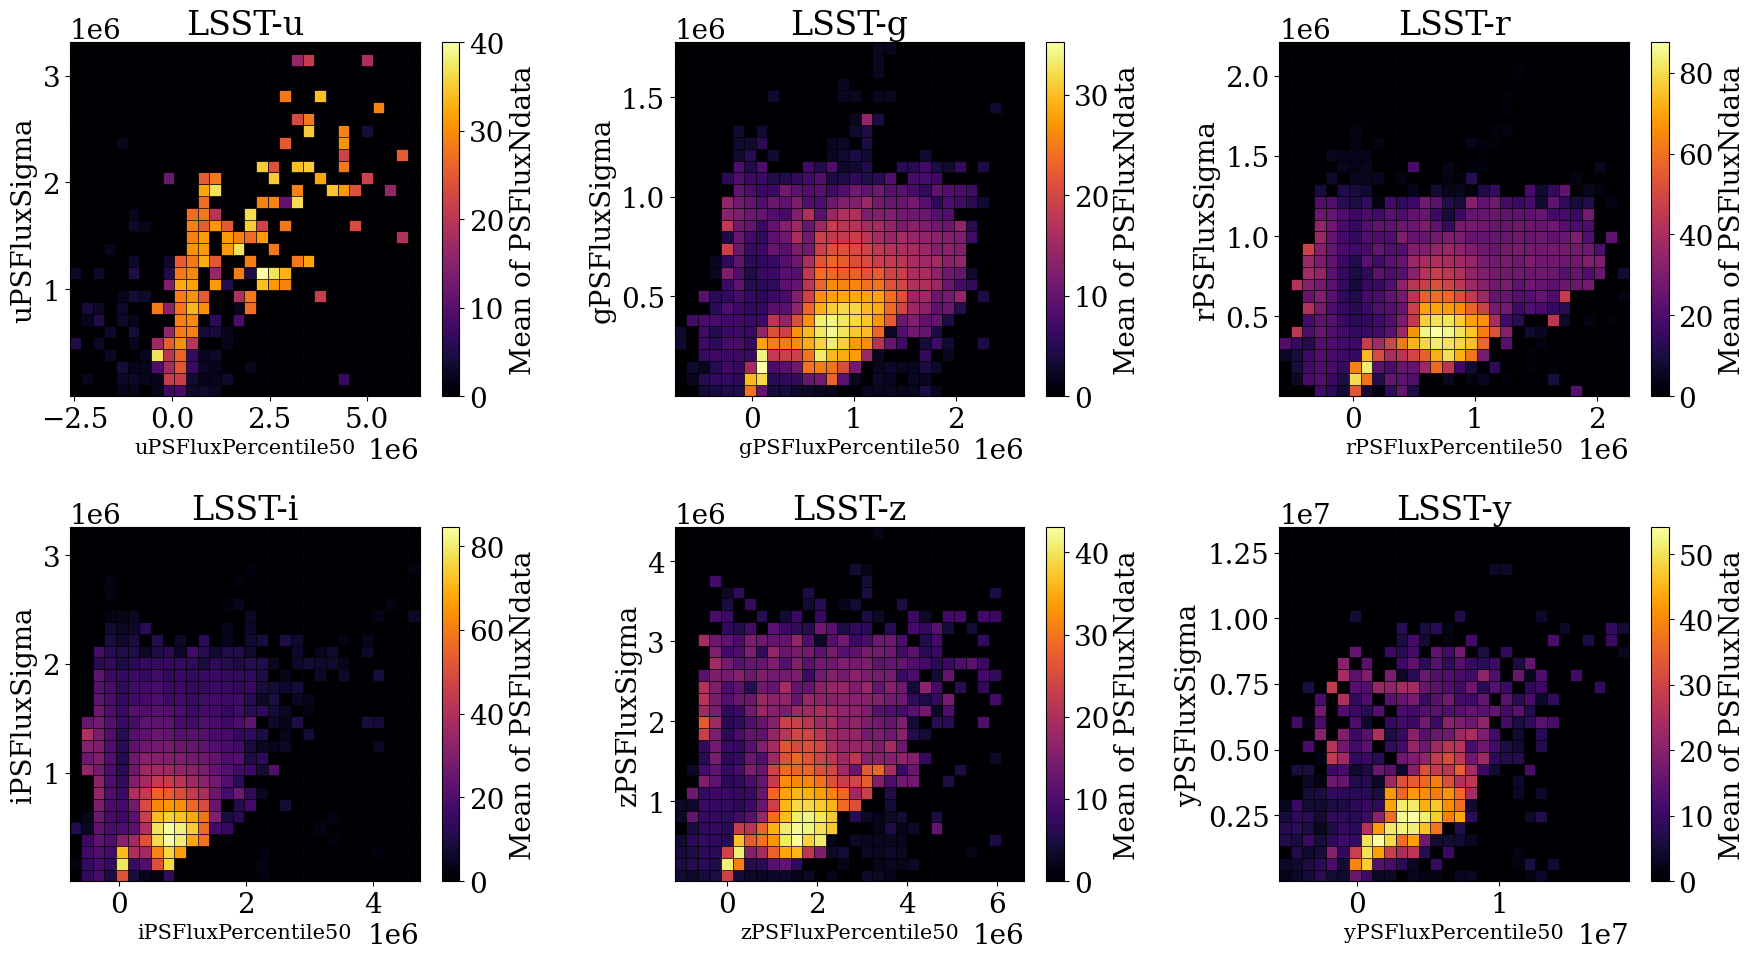

100%|██████████| 30/30 [00:01<00:00, 21.61it/s]


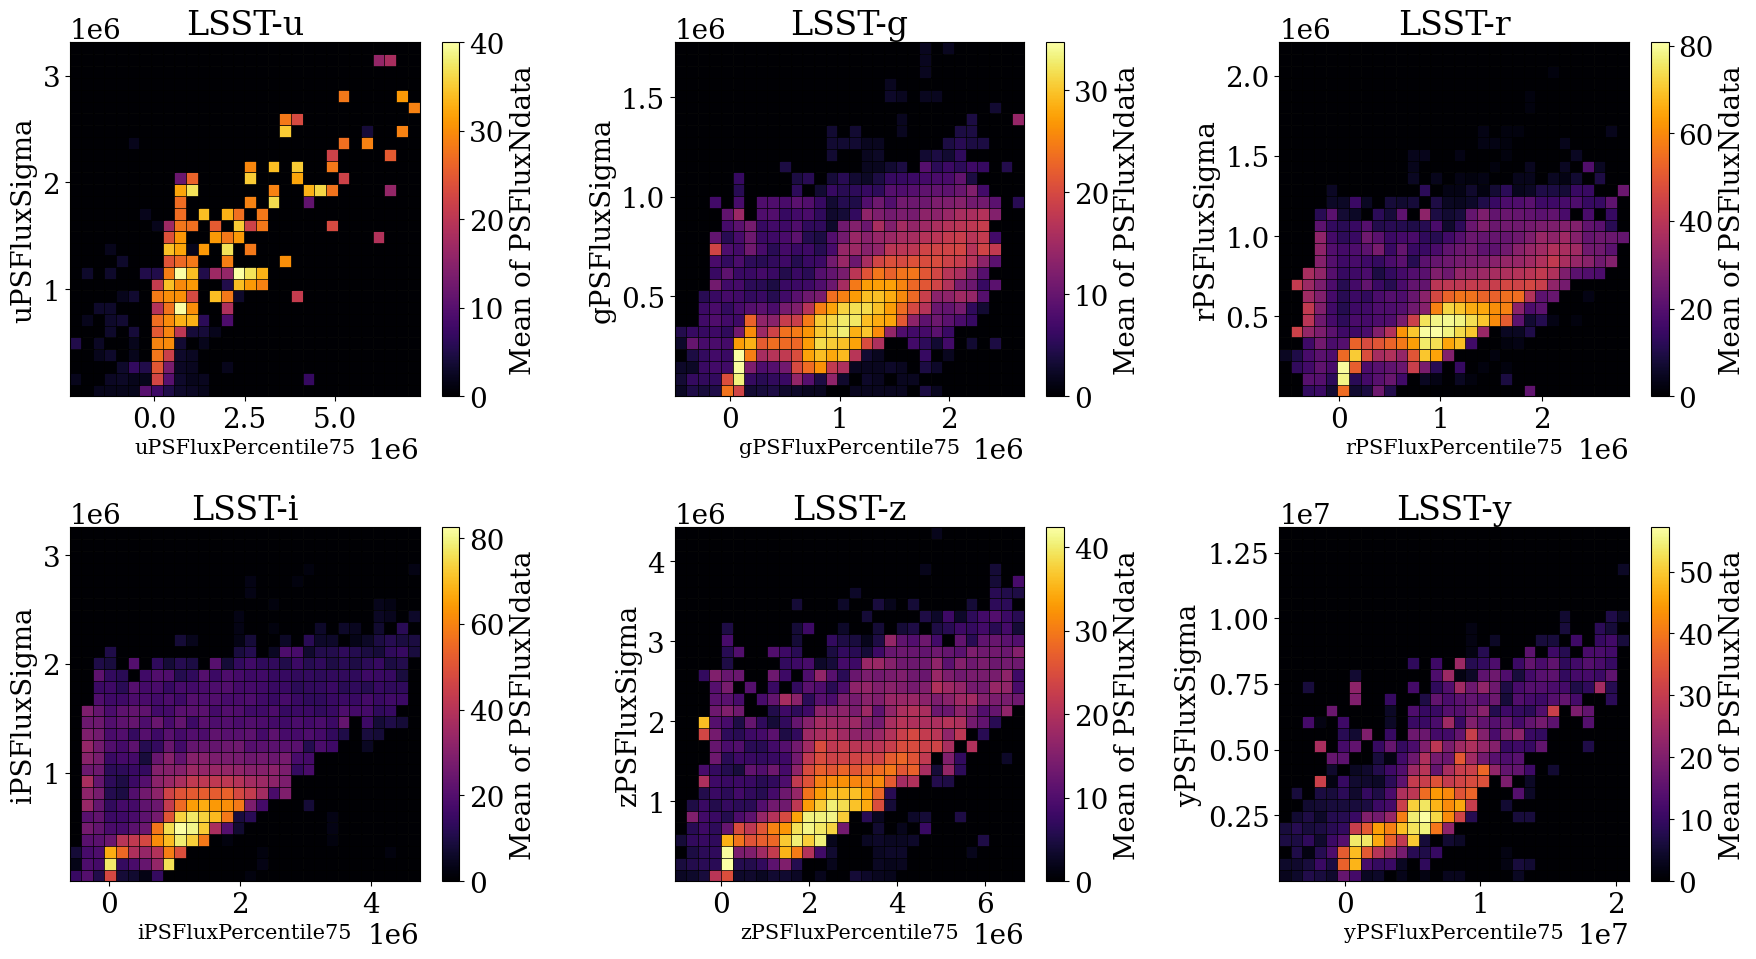

100%|██████████| 30/30 [00:01<00:00, 21.60it/s]


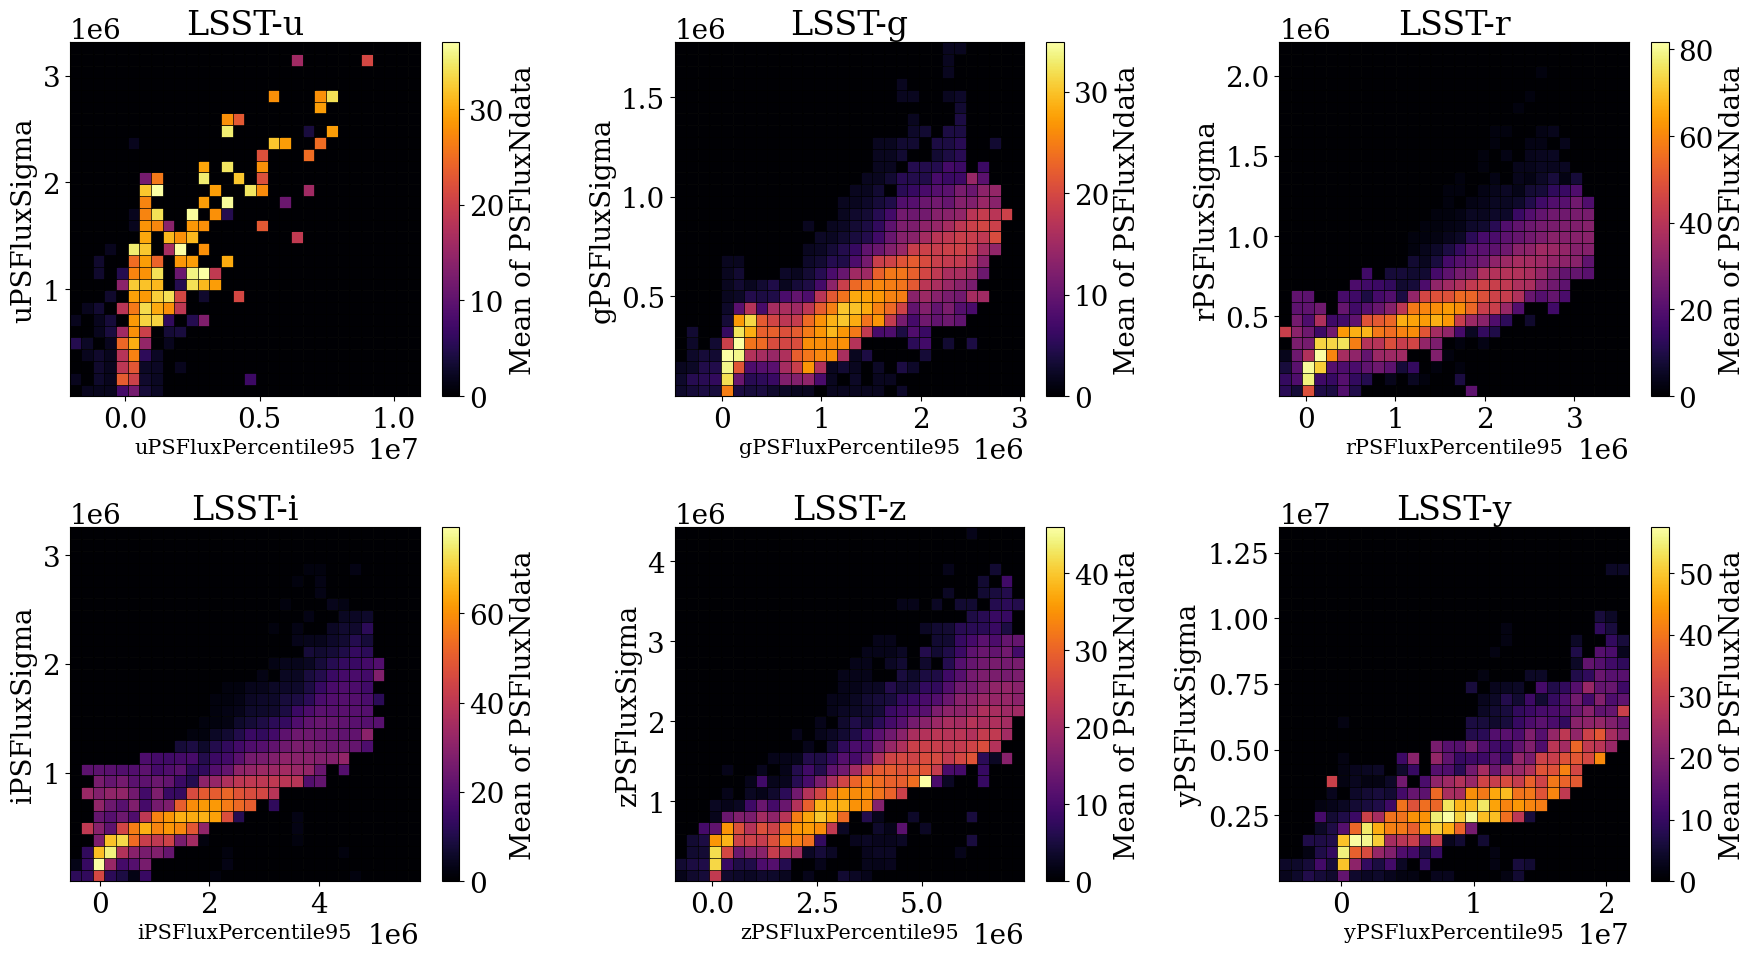

100%|██████████| 30/30 [00:01<00:00, 21.52it/s]


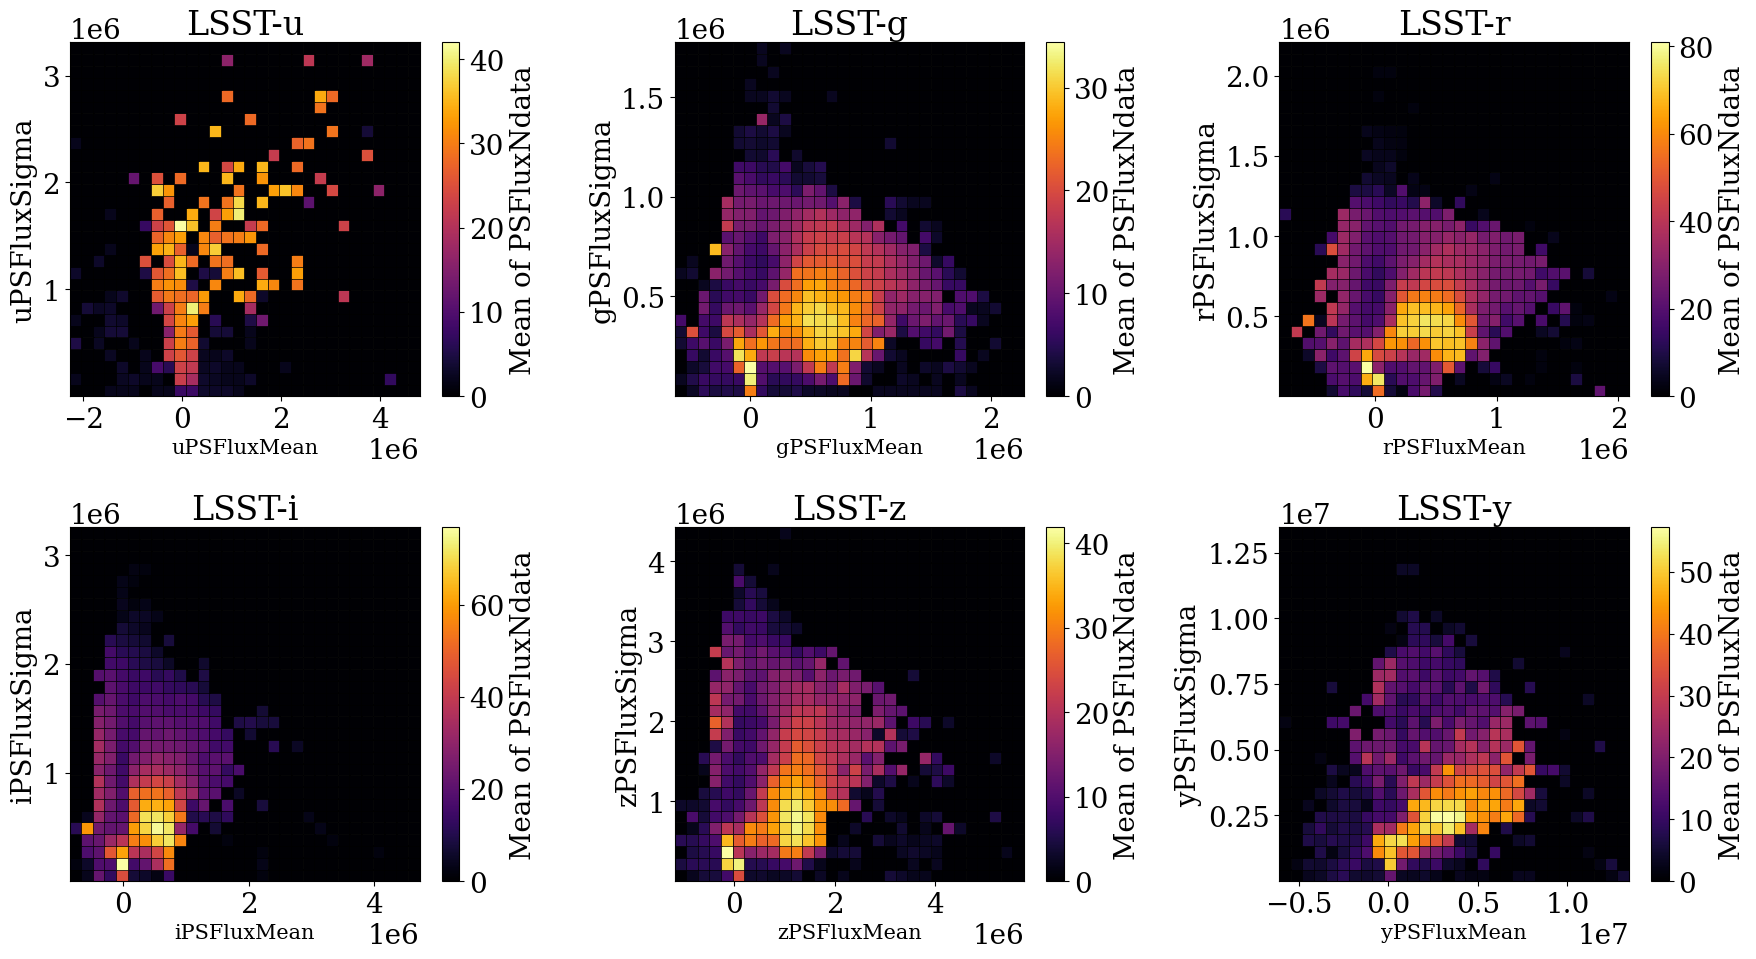

100%|██████████| 30/30 [00:01<00:00, 21.62it/s]


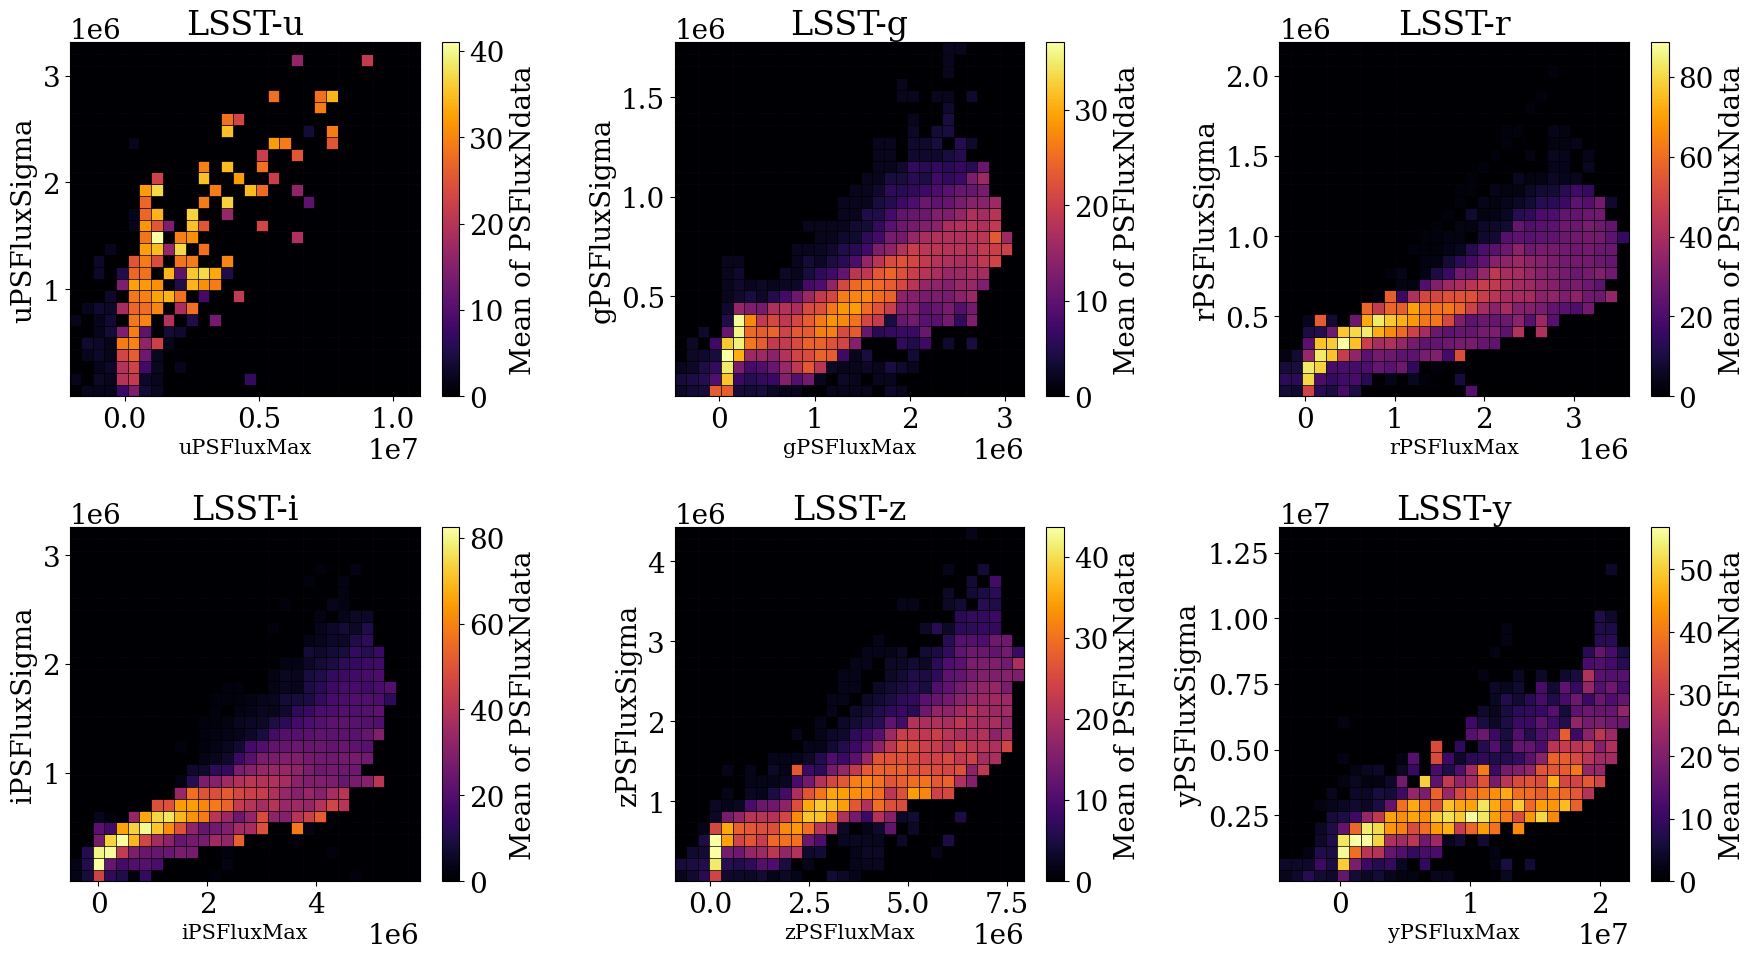

In [23]:
make_plot_avg(table, bins=30, xvar='PSFluxPercentile05')
make_plot_avg(table, bins=30, xvar='PSFluxPercentile25')
make_plot_avg(table, bins=30, xvar='PSFluxPercentile50')
make_plot_avg(table, bins=30, xvar='PSFluxPercentile75')
make_plot_avg(table, bins=30, xvar='PSFluxPercentile95')
make_plot_avg(table, bins=30, xvar='PSFluxMean')
make_plot_avg(table, bins=30, xvar='PSFluxMax')
